In [1]:
!pip install roboflow torch torchvision opencv-python albumentations matplotlib

In [3]:
import os, glob, random, cv2, torch, numpy as np
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from roboflow import Roboflow

In [19]:
rf = Roboflow(api_key="lYmuRiS0JK2RXhRpkR8F")
project = rf.workspace("youssefs-workspace-kgbku").project("wall-segmentation-cmjwq")
version = project.version(4)
dataset = version.download("png-mask-semantic")  # <<<< keep this

# train_img_dir = os.path.join(dataset.location, "train", "images")
# train_msk_dir = os.path.join(dataset.location, "train", "masks")
# val_img_dir   = os.path.join(dataset.location, "valid", "images")
# val_msk_dir   = os.path.join(dataset.location, "valid", "masks")

loading Roboflow workspace...
loading Roboflow project...


In [21]:
# === END-TO-END "BEFORE TRAINING" for YOLOv8-Seg ===
# - Converts Roboflow PNG-mask (mixed images+*_mask.png per split) -> YOLOv8 segmentation format
# - Writes data.yaml
# - Validates labels (normalization, counts)
# - Saves a few polygon overlays for sanity-check

from pathlib import Path
import os, shutil, random, csv, yaml, cv2, numpy as np

# ---------------- CONFIG (EDIT THIS) ----------------
SRC_ROOT = Path(r"C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4")  # Roboflow export root
MASK_SUFFIX = "_mask.png"
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
OUT_ROOT = SRC_ROOT / "yolo_v8_seg"         # output YOLO dataset
SINGLE_CLASS_NAME = "wall"                  # used if we detect a single foreground class
MIN_CNT_AREA = 10                           # ignore tiny contours in mask->poly
EPS_FRAC = 0.001                            # polygon simplification (smaller = more points)
N_OVERLAYS = 8                              # number of sample overlays to save
# ----------------------------------------------------

def pick_splits(src: Path):
    s = []
    for name in ["train", "val", "valid", "test"]:
        if (src/name).exists(): s.append(name)
    if not s: raise FileNotFoundError("No splits found (expected train/val/valid/test).")
    return s

def to_index_mask(msk):
    """Return int index mask from 1/3/4 channel PNGs."""
    if msk.ndim == 2:
        return msk.astype(np.int32)
    if msk.ndim == 3:
        C = msk.shape[2]
        if C == 1:
            return msk[:,:,0].astype(np.int32)
        # drop alpha if present, color->index mapping
        rgb = msk[:,:,:3]
        H,W,_ = rgb.shape
        flat = rgb.reshape(-1,3)
        _, inv = np.unique(flat, axis=0, return_inverse=True)
        return inv.reshape(H,W).astype(np.int32)
    return np.squeeze(msk).astype(np.int32)

def list_pairs(mixed_dir: Path):
    imgs = []
    for f in mixed_dir.iterdir():
        if f.is_file() and f.suffix.lower() in IMG_EXTS:
            if (mixed_dir / f"{f.stem}{MASK_SUFFIX}").exists():
                imgs.append(f)
    return sorted(imgs)

def load_classes_csv(split_dir: Path):
    """Robust reader for _classes.csv => {pixel_value: name} or None."""
    csv_path = split_dir / "_classes.csv"
    if not csv_path.exists(): return None
    rows = []
    with csv_path.open(newline="", encoding="utf-8") as f:
        rdr = csv.reader(f)
        for row in rdr:
            if not row: continue
            if len(row) >= 2 and row[0].strip().isdigit():
                rows.append((int(row[0].strip()), row[1].strip()))
            else:
                head = row[0].strip().lower()
                if head in {"pixel value","index","id","class","name"}: continue
                rows.append((None, row[0].strip()))
    if rows and rows[0][0] is None:  # only names given; assume 1..K
        return {i+1: rows[i][1] for i in range(len(rows))}
    return {pix:nm for pix,nm in rows if pix is not None}

def infer_pixel_values(src_root: Path, splits):
    """Scan a subset of masks to infer unique nonzero pixel values."""
    vals = set()
    for sp in splits:
        d = src_root/sp
        for i, img_p in enumerate(list_pairs(d)[:200]):  # sample up to 200
            m = cv2.imread(str(d / f"{img_p.stem}{MASK_SUFFIX}"), cv2.IMREAD_UNCHANGED)
            if m is None: continue
            idx = to_index_mask(m)
            u = np.unique(idx)
            vals.update(int(v) for v in u if int(v) != 0)
    return sorted(vals)

def build_class_map(src_root: Path, splits):
    """Return {pixel_value: class_name}."""
    # Prefer _classes.csv if present (train/val order)
    for pref in ["train","val","valid"]:
        if (src_root/pref).exists():
            cm = load_classes_csv(src_root/pref)
            if cm: return cm
    # Else infer from mask uniques
    pix_vals = infer_pixel_values(src_root, splits)
    if not pix_vals:
        raise RuntimeError("No foreground pixels found (only background=0).")
    if len(pix_vals) == 1:
        return {pix_vals[0]: SINGLE_CLASS_NAME}
    # multi-class: generic names
    return {pv: f"class_{pv}" for pv in pix_vals}

def ensure_dirs(root: Path):
    (root/"images").mkdir(parents=True, exist_ok=True)
    (root/"labels").mkdir(parents=True, exist_ok=True)

def mask_to_polys(idx_mask, pix_val):
    bin_mask = (idx_mask == pix_val).astype(np.uint8)
    if bin_mask.max() == 0: return []
    bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cnts,_ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polys = []
    for c in cnts:
        if cv2.contourArea(c) < MIN_CNT_AREA: continue
        polys.append(c.squeeze(1))
    return polys

def poly_to_yolo_line(poly, cls_id, w, h):
    xs = poly[:,0].astype(np.float32); ys = poly[:,1].astype(np.float32)
    x_min, x_max, y_min, y_max = xs.min(), xs.max(), ys.min(), ys.max()
    cx = (x_min + x_max) / 2.0 / w
    cy = (y_min + y_max) / 2.0 / h
    bw = (x_max - x_min) / w
    bh = (y_max - y_min) / h
    pts = []
    for x,y in zip(xs, ys):
        pts += [x / w, y / h]
    return f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f} " + " ".join(f"{p:.6f}" for p in pts)

def convert_split(src_root: Path, out_root: Path, split: str, class_map: dict, names_list: list):
    src = src_root / split
    out = out_root / split
    ensure_dirs(out)
    kept, skipped = 0, 0
    for img_p in list_pairs(src):
        mask_p = src / f"{img_p.stem}{MASK_SUFFIX}"
        # copy image
        dst_img = out/"images"/img_p.name
        dst_lbl = out/"labels"/f"{img_p.stem}.txt"
        if not dst_img.parent.exists(): dst_img.parent.mkdir(parents=True, exist_ok=True)
        if not dst_lbl.parent.exists(): dst_lbl.parent.mkdir(parents=True, exist_ok=True)
        # copy without re-encoding
        shutil.copy2(img_p, dst_img)

        # read mask -> polygons
        m = cv2.imread(str(mask_p), cv2.IMREAD_UNCHANGED)
        if m is None:
            skipped += 1
            open(dst_lbl, "w").close()
            continue
        idx = to_index_mask(m)
        H, W = idx.shape[:2]
        lines = []
        for pix_val, cname in class_map.items():
            polys = mask_to_polys(idx, pix_val)
            for poly in polys:
                if len(poly) < 3: continue
                eps = EPS_FRAC * (W + H)
                approx = cv2.approxPolyDP(poly, epsilon=eps, closed=True).reshape(-1,2)
                if len(approx) < 3: approx = poly
                cls_id = names_list.index(cname)  # 0..K-1
                lines.append(poly_to_yolo_line(approx, cls_id, W, H))
        with open(dst_lbl, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        kept += 1
    return kept, skipped

def write_yaml(out_root: Path, names_list: list, prefer_val_name: str):
    y = {
        "path": str(out_root.resolve()),
        "train": str((out_root/"train"/"images").resolve()),
        "val":   str((out_root/prefer_val_name/"images").resolve()),
        "names": {i: n for i, n in enumerate(names_list)}
    }
    if (out_root/"test").exists():
        y["test"] = str((out_root/"test"/"images").resolve())
    with open(out_root/"data.yaml", "w", encoding="utf-8") as f:
        yaml.safe_dump(y, f, sort_keys=False, allow_unicode=True)

def validate_labels(out_root: Path):
    IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    splits = [s for s in ["train","val","valid","test"] if (out_root/s).exists()]
    print("\n[Pre-flight] Split counts & missing labels")
    for s in splits:
        img_dir = out_root/s/"images"
        lbl_dir = out_root/s/"labels"
        imgs = sorted([p for p in img_dir.glob("*.*") if p.suffix.lower() in IMG_EXTS])
        lbls = {p.stem for p in lbl_dir.glob("*.txt")}
        missing = [p.name for p in imgs if p.stem not in lbls]
        print(f"  {s:5s}: {len(imgs)} images, {len(lbls)} labels, missing: {len(missing)}")
        if missing[:5]: print("    sample missing:", missing[:5])

    print("\n[Pre-flight] Label syntax/normalization checks")
    bad = []
    for s in splits:
        for p in (out_root/s/"labels").glob("*.txt"):
            lines = p.read_text().strip().splitlines()
            for ln in lines:
                vals = ln.strip().split()
                if len(vals) < 11:  # class + cx cy w h + 6+ coords
                    bad.append((p.name, "too_few_numbers")); break
                nums = list(map(float, vals))
                _, cx, cy, w, h = nums[:5]
                pts = nums[5:]
                if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 < w <= 1 and 0 < h <= 1):
                    bad.append((p.name, "bbox_not_normalized")); break
                if min(pts) < 0 or max(pts) > 1:
                    bad.append((p.name, "poly_not_normalized")); break
    print("  Bad labels:", len(bad))
    if bad[:5]: print("   first few:", bad[:5])

def save_overlays(out_root: Path, split_for_preview: str, k=N_OVERLAYS):
    import math
    ov_dir = out_root / "_overlays"
    ov_dir.mkdir(exist_ok=True)
    img_dir = out_root/split_for_preview/"images"
    lbl_dir = out_root/split_for_preview/"labels"
    imgs = [p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS]
    if not imgs:
        print("[Overlay] No images to preview.")
        return
    sample = random.sample(imgs, k=min(k, len(imgs)))
    for p in sample:
        im = cv2.imread(str(p))
        h, w = im.shape[:2]
        lbl = lbl_dir / (p.stem + ".txt")
        if lbl.exists():
            for ln in lbl.read_text().strip().splitlines():
                a = list(map(float, ln.split()))
                pts = (np.array(a[5:], dtype=np.float32).reshape(-1,2) * [w,h]).astype(int)
                if len(pts) >= 3:
                    cv2.polylines(im, [pts], True, (0,255,0), 2)
        cv2.imwrite(str(ov_dir / f"{p.stem}_overlay.jpg"), im)
    print(f"[Overlay] Saved {len(sample)} overlays to: {ov_dir}")

# ---------------- RUN ALL STEPS ----------------
splits = pick_splits(SRC_ROOT)
print("Found splits:", splits)

class_map = build_class_map(SRC_ROOT, splits)  # {pixel_value: class_name}
names = list(dict.fromkeys(class_map.values()))  # preserve order & unique
print("Class map (pixel -> name):", class_map)
print("YOLO names:", names)

# Fresh output folder
if OUT_ROOT.exists():
    print(f"Removing old folder: {OUT_ROOT}")
    shutil.rmtree(OUT_ROOT)
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Convert each split
for sp in splits:
    kept, skipped = convert_split(SRC_ROOT, OUT_ROOT, sp, class_map, names)
    print(f"[{sp}] converted: {kept} files, masks missing/empty: {skipped}")

# data.yaml
val_name = "val" if (OUT_ROOT/"val").exists() else ("valid" if (OUT_ROOT/"valid").exists() else "train")
write_yaml(OUT_ROOT, names, val_name)
print("Wrote:", OUT_ROOT/"data.yaml")

# Pre-flight validation
validate_labels(OUT_ROOT)

# Visual sanity-check overlays (on val/valid/train fallback)
preview_split = val_name
save_overlays(OUT_ROOT, preview_split, k=N_OVERLAYS)

print("\nAll set. Use this in your train cell:\n")
print(f'  from ultralytics import YOLO')
print(f'  DATA_YAML = r"{str((OUT_ROOT/"data.yaml").resolve())}"')
print(f'  YOLO("yolov8s-seg.pt").train(data=DATA_YAML, imgsz=1024, epochs=200, batch=4, device=0, workers=2, cos_lr=True, close_mosaic=10)')


Found splits: ['train', 'valid', 'test']
Class map (pixel -> name): {0: 'background', 1: 'walls'}
YOLO names: ['background', 'walls']
Removing old folder: C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg
[train] converted: 135 files, masks missing/empty: 0
[valid] converted: 6 files, masks missing/empty: 0
[test] converted: 6 files, masks missing/empty: 0
Wrote: C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\data.yaml

[Pre-flight] Split counts & missing labels
  train: 135 images, 135 labels, missing: 0
  valid: 6 images, 6 labels, missing: 0
  test : 6 images, 6 labels, missing: 0

[Pre-flight] Label syntax/normalization checks
  Bad labels: 0
[Overlay] Saved 6 overlays to: C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\_overlays

All set. Use this in your train cell:

  from ultralytics import YOLO
  DATA_YAML = r"C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\data.yaml"
  YOLO("yol

In [25]:
from ultralytics import YOLO

DATA_YAML = r"C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\data.yaml"

model = YOLO("yolov8s-seg.pt")  # or "yolov8n-seg.pt" if VRAM is tight
model.train(
    data=DATA_YAML,
    imgsz=1024,
    epochs=200,
    batch=4,
    device=0,      # use "cpu" if no GPU
    workers=2,
    cos_lr=True,
    close_mosaic=10,
    project="runs/segment",
    name="wall_1024_miou"
)


New https://pypi.org/project/ultralytics/8.3.178 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.175  Python-3.11.9 torch-2.3.1 CUDA:0 (Quadro M6000 24GB, 24576MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

train: Scanning C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\train\labels... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<00:00, 581.90it/s]

train: New cache created: C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.20.0 ms, read: 71.718.6 MB/s, size: 32.5 KB)


val: Scanning C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\valid\labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 666.66it/s]

val: New cache created: C:\Users\win11\Desktop\Ebni\segmentation\Wall-segmentation-4\yolo_v8_seg\valid\labels.cache


Plotting labels to runs\segment\wall_1024_miou\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs\segment\wall_1024_miou
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      6.32G      2.602      5.027      3.116      2.702        105       1024: 100%|██████████| 34/34 [00:20<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all          6         86     0.0858      0.581     0.0632     0.0166          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.33G      2.406      3.657      2.571      2.635        134       1024: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          6         86      0.128      0.156     0.0957     0.0326          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      6.33G      2.371      3.617      2.391      2.643         68       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          6         86     0.0638     0.0437     0.0147    0.00293          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.33G      2.462      3.541       2.46      2.628        151       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          6         86          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      6.33G      2.327      3.363      2.363      2.628        126       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all          6         86     0.0104      0.025    0.00354    0.00108          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.33G      2.288      3.361      2.377      2.627         94       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.592     0.0125    0.00669    0.00155          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      6.33G      2.153      3.264      2.266       2.52        144       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all          6         86     0.0224     0.0187     0.0124    0.00401          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.33G      2.136      3.265      2.288      2.538        155       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all          6         86     0.0686      0.296      0.045     0.0111          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.33G      2.081      3.179      2.201      2.534        138       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all          6         86     0.0929      0.258     0.0668      0.022          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      6.33G      2.047       3.11      2.162      2.488        247       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all          6         86      0.119      0.233     0.0661     0.0208          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.33G      2.006      3.097      2.184      2.446         62       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.185      0.285      0.227     0.0575          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.33G      1.953      3.104      2.132      2.416         52       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all          6         86      0.708       0.25      0.283     0.0654          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      6.33G       1.96      2.957      2.128       2.43         84       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86     0.0591      0.106     0.0411     0.0125          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.33G       1.92      2.965      2.112      2.451         84       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.873        0.5      0.575      0.162          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      6.33G      1.877      2.954      2.068      2.361        132       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          6         86      0.774      0.333      0.344     0.0619          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.33G      1.836      2.893      2.024      2.354        132       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all          6         86      0.744      0.569      0.616      0.165          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      6.33G      1.868      2.885      2.006      2.366        145       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.709        0.5      0.454       0.13      0.575      0.167      0.038    0.00592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      6.33G      1.915      2.947      2.073      2.403        160       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all          6         86          1       0.32      0.513      0.108      0.593     0.0833     0.0491    0.00578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      6.33G      1.832      2.917      2.038      2.321         89       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.321      0.523      0.411      0.126     0.0147     0.0833    0.00974   0.000974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.33G      1.861      2.942      2.064      2.316         83       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.374      0.624      0.491      0.135          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.33G       1.78      2.843      1.997      2.277         97       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.802      0.417      0.377     0.0948   0.000286    0.00625   0.000145   1.45e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      6.33G      1.768      2.892      1.995      2.263        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all          6         86      0.836      0.417      0.511      0.144    0.00909     0.0833    0.00655    0.00131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      6.33G      1.749      2.935      2.018      2.255        177       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all          6         86      0.871      0.483      0.457       0.15      0.638      0.167     0.0784     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      6.33G      1.734      2.854       1.99      2.242         74       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all          6         86      0.865        0.5      0.455     0.0917          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      6.33G      1.768      2.892      1.975      2.252        149       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.498      0.562      0.569     0.0935          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      6.33G      1.754      2.878      2.006      2.228         97       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.633      0.581      0.626       0.22      0.107      0.167     0.0497    0.00989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      6.33G      1.727      2.714      1.926      2.217         78       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.449      0.631      0.619      0.161     0.0762      0.167     0.0356    0.00358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      6.33G      1.729      2.753      1.945      2.215         63       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all          6         86      0.345      0.421      0.394      0.115   0.000861    0.00625   0.000183   1.83e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      6.33G      1.703      2.837      1.952      2.175        125       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86       0.32      0.554      0.447      0.101     0.0956      0.167     0.0455    0.00776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      6.33G      1.725      2.868      1.927      2.187        145       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.949      0.417      0.616      0.208      0.711       0.25       0.19      0.019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      6.33G      1.684      2.865      1.953      2.183        171       1024: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86       0.87        0.5      0.568      0.207     0.0497      0.167     0.0238    0.00703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.33G      1.675       2.79      1.883      2.165         91       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.382      0.619      0.522      0.184      0.749      0.417      0.308     0.0711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      6.33G      1.682      2.748      1.896        2.2        165       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.901        0.5      0.603      0.235      0.803      0.167      0.177     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      6.33G      1.668      2.732      1.865      2.161         66       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.863      0.446       0.55      0.215      0.108      0.333       0.11     0.0223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      6.33G      1.653      2.762      1.862      2.125         93       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.888        0.5      0.508      0.198       0.72      0.333       0.28     0.0393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.33G      1.636      2.683      1.836      2.115        220       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.968      0.417      0.563      0.213      0.639      0.333      0.199     0.0242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.33G       1.65      2.845      1.925      2.134         71       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86       0.99        0.5       0.62      0.214      0.142       0.25      0.109     0.0151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      6.33G      1.633      2.752      1.846      2.121        117       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.904        0.5      0.581      0.231     0.0932       0.23     0.0798     0.0091



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      6.33G      1.605      2.639      1.807      2.114        124       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86       0.37       0.65      0.542      0.169       0.73     0.0833     0.0858     0.0189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      6.33G      1.582      2.754      1.824      2.086        121       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all          6         86      0.356      0.713      0.613      0.245      0.677      0.333      0.204     0.0236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.33G      1.643      2.729      1.816        2.1        121       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.395      0.681       0.56      0.241      0.237        0.5      0.274     0.0424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      6.33G      1.605       2.73      1.809      2.042         81       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all          6         86      0.312      0.608       0.52       0.22      0.777      0.417      0.293     0.0449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.33G       1.64      2.715      1.802      2.095         59       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.874      0.417      0.534      0.187      0.725       0.41      0.243      0.031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.33G      1.603      2.775      1.832      2.079        101       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.962      0.417      0.602      0.242      0.618      0.167     0.0689    0.00982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      6.33G      1.601      2.656      1.828      2.089        136       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.369      0.662      0.541      0.213      0.133       0.25      0.102     0.0162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      6.33G      1.574      2.722      1.822      2.075        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86       0.39      0.731      0.606      0.222      0.659      0.167     0.0607     0.0117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      6.33G      1.587      2.665      1.809      2.073         68       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all          6         86      0.395      0.657      0.603      0.238      0.201      0.393      0.226     0.0423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.33G        1.6       2.69      1.832      2.091         49       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86          1      0.492      0.611      0.223      0.916      0.412      0.378     0.0853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.33G      1.598      2.706      1.826      2.069         86       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.227      0.567      0.389      0.128      0.628       0.25      0.134     0.0165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      6.33G      1.542      2.654      1.795      2.055        102       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.421      0.606      0.546      0.212      0.658      0.167     0.0603    0.00812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      6.33G      1.538      2.621      1.763      2.033        213       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86       0.46      0.625      0.617       0.24      0.111      0.167     0.0568     0.0092



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.33G      1.546      2.702      1.778      2.044        115       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.404      0.681      0.632      0.231      0.119       0.25     0.0874     0.0133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.33G      1.566      2.644      1.794      2.058        139       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86        0.4      0.669      0.643      0.187      0.101       0.25     0.0902     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      6.33G      1.562      2.744      1.782      2.038         95       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.402      0.669      0.617      0.227      0.121       0.25     0.0922     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      6.33G      1.558      2.702      1.788      2.042         80       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.852        0.5      0.507      0.207     0.0478      0.167     0.0591     0.0102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      6.33G      1.552      2.673      1.774      2.029        105       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.927      0.487      0.558      0.209      0.581      0.167     0.0482    0.00686



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      6.33G      1.553      2.727      1.768      2.049         77       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.429      0.588      0.575      0.263      0.709      0.333       0.17     0.0265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      6.33G      1.529      2.661      1.753      2.031        109       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.919       0.43      0.618      0.283      0.746      0.333      0.263     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      6.33G      1.552      2.644      1.779       2.05         82       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.924        0.5      0.596      0.253      0.764      0.333      0.256     0.0525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      6.33G      1.515      2.695       1.77      2.026        145       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.859      0.424      0.553      0.208      0.115      0.417      0.181     0.0394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      6.33G       1.55       2.65      1.743      2.027        132       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.869       0.47      0.594      0.212       0.71       0.25      0.197     0.0407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      6.33G      1.531      2.678       1.75      2.012        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.927      0.487       0.63       0.25      0.659       0.25      0.096     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      6.33G       1.55      2.644      1.762      2.023        122       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.332      0.725      0.552       0.18      0.599      0.167     0.0447    0.00447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.33G      1.554      2.625       1.77      2.039        183       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.371      0.675        0.6      0.194      0.621     0.0833     0.0293    0.00293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      6.33G      1.543      2.599      1.743      2.044        132       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.429      0.669      0.646      0.264      0.642      0.167      0.118     0.0126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      6.33G      1.474      2.703      1.738       1.97        202       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.907        0.5      0.595       0.28      0.297       0.49      0.405     0.0902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      6.33G      1.498      2.655      1.702      1.992        149       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.907        0.5      0.583      0.209      0.194      0.333      0.156     0.0278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.33G      1.499      2.621      1.716      1.984         90       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.861        0.5      0.557      0.178      0.561     0.0833     0.0188     0.0019



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      6.33G      1.463      2.679      1.707      1.958        131       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.356      0.669      0.624       0.26      0.166      0.417       0.22     0.0329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      6.33G      1.487      2.611      1.711      1.976         77       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.334      0.681       0.59      0.252      0.216      0.417      0.203     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      6.33G       1.51      2.595      1.735      1.981        145       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.972      0.417      0.613      0.273      0.751      0.333      0.302     0.0463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.33G      1.477      2.573      1.683      1.971        122       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.976        0.5       0.66      0.304      0.708       0.25      0.129     0.0333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      6.33G      1.468      2.613      1.705      1.967         56       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86          1      0.496      0.674       0.26     0.0989       0.25     0.0676     0.0106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      6.33G      1.481      2.593      1.719      1.974        129       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86       0.35      0.606      0.586      0.257      0.745       0.25      0.259     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      6.33G      1.506       2.61      1.733       1.99        123       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.371        0.7      0.562      0.268      0.249      0.413      0.303     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.33G      1.439      2.569      1.664      1.937        186       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86          1      0.415      0.603       0.29      0.839      0.417      0.346      0.078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      6.33G      1.493       2.65      1.697      1.995         69       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.488      0.619      0.645      0.238       0.77       0.25      0.216     0.0449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.33G       1.43      2.521      1.654      1.942        154       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.458      0.633      0.651      0.277      0.841       0.25      0.231     0.0481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      6.33G       1.46      2.601      1.693      1.961         86       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.365      0.731      0.665      0.309      0.874        0.5      0.408     0.0913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.33G      1.441      2.663      1.692      1.927        125       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.351      0.769      0.641      0.309      0.826      0.333      0.312     0.0667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.33G      1.454      2.653      1.671      1.943        164       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86       0.34      0.573      0.516       0.19      0.833      0.166      0.156     0.0328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      6.33G      1.449      2.515      1.645      1.977        110       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.425      0.669      0.581      0.243        0.2      0.333      0.228     0.0429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.33G      1.462      2.536      1.638      1.965        111       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.378      0.781      0.669      0.289      0.334      0.417      0.325     0.0517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.33G      1.407      2.552       1.61      1.909        134       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all          6         86      0.372      0.706      0.634      0.253      0.782      0.324      0.193     0.0435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.33G      1.431      2.617      1.651      1.923         83       1024: 100%|██████████| 34/34 [00:19<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.383        0.7      0.608      0.241      0.717      0.333      0.155     0.0266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      6.33G      1.432      2.538      1.621      1.926        108       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.409       0.65      0.615      0.233      0.692       0.25      0.147     0.0188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      6.33G      1.407      2.607      1.633      1.898        179       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.987        0.5      0.626      0.275      0.734       0.25      0.126     0.0274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      6.33G      1.432      2.637       1.68      1.922         38       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.914        0.5      0.604      0.261       0.13       0.25     0.0747     0.0128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      6.33G      1.411      2.416      1.607      1.935         99       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86       0.41      0.706      0.671      0.291      0.721       0.25      0.145     0.0191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      6.33G      1.417      2.461      1.613      1.936        257       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.447      0.711       0.66      0.283      0.867      0.333      0.313      0.039



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      6.33G      1.396      2.634      1.651      1.915         60       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.395      0.694      0.589      0.273      0.771      0.333      0.256     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      6.33G      1.434      2.529       1.61      1.944         96       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.385      0.703      0.643      0.275      0.145       0.25      0.136     0.0282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      6.33G      1.412      2.555      1.643      1.938         72       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.494      0.706      0.649      0.297      0.799      0.167      0.164     0.0203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      6.33G      1.375      2.473      1.586      1.886        125       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.561      0.669      0.671      0.256      0.644     0.0833     0.0291     0.0058



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      6.33G      1.379      2.576      1.608      1.856        133       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.406        0.7      0.622      0.272      0.855      0.417      0.378     0.0985



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      6.33G      1.411      2.589      1.647      1.901        141       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.382        0.7      0.598      0.294          1      0.311      0.381     0.0982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.33G      1.403       2.61      1.636      1.899         59       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.384      0.663      0.562      0.293      0.845      0.417      0.363      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      6.33G       1.36      2.476      1.585      1.874        141       1024: 100%|██████████| 34/34 [00:19<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.401      0.613      0.638      0.281       0.71       0.25      0.188     0.0458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      6.33G      1.358      2.558      1.604      1.865         99       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.433      0.691      0.635      0.292      0.677      0.333      0.147     0.0451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      6.33G      1.423      2.528      1.616        1.9        142       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86        0.5      0.619      0.658      0.342      0.844       0.37      0.377     0.0731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      6.33G      1.384      2.551      1.587      1.862        146       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.415       0.67      0.618      0.269      0.767      0.333      0.237     0.0509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      6.33G      1.393      2.484      1.585      1.899        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.435      0.632      0.581      0.227      0.691      0.167      0.127      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      6.33G       1.38      2.643      1.587      1.849         81       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.774       0.53      0.579      0.212      0.647      0.167      0.113     0.0114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      6.33G      1.381      2.565      1.631      1.884        138       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.391      0.675      0.602      0.254      0.278      0.333      0.236     0.0461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      6.33G      1.365       2.48      1.566      1.857         58       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.408      0.731      0.657      0.315      0.787       0.25       0.19     0.0639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      6.33G       1.38      2.632      1.601      1.868        142       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.494      0.713      0.687      0.333      0.732       0.25      0.214     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      6.33G      1.349      2.557      1.568      1.865         72       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.554      0.706      0.689      0.324      0.218      0.333      0.202     0.0448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.33G      1.356      2.479      1.578      1.862         57       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.404      0.767      0.661      0.268      0.772      0.333      0.194     0.0391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.33G      1.342      2.496      1.549      1.858        119       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.418      0.719      0.681      0.315       0.71       0.25      0.128     0.0347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      6.33G      1.363       2.48      1.565      1.855        125       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all          6         86      0.573       0.61      0.625      0.274      0.163      0.333      0.127     0.0283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      6.33G       1.32       2.49      1.521       1.84        118       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.414      0.725      0.583      0.261      0.722      0.333      0.228     0.0359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.33G      1.368        2.5       1.55      1.871        160       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.469       0.74      0.592      0.292      0.342       0.34      0.164     0.0483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      6.33G      1.343        2.5      1.567      1.848         89       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all          6         86      0.531      0.738      0.669      0.344      0.272      0.417      0.331     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      6.33G      1.353      2.507      1.566      1.849         93       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.531      0.725      0.669      0.345      0.777      0.417      0.332      0.066



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      6.33G      1.365      2.571      1.581      1.875         66       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.474      0.738      0.697      0.365      0.777      0.333      0.237     0.0552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.33G      1.316      2.475      1.527      1.835        155       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.511      0.706      0.681      0.285      0.812      0.333      0.251     0.0309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      6.33G      1.297      2.393      1.469      1.811         88       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.524      0.725      0.688      0.324       0.78      0.333       0.28     0.0317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      6.33G      1.297      2.475      1.496      1.812        103       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86       0.52      0.706      0.689       0.37      0.771      0.333      0.237     0.0624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      6.33G      1.345      2.421      1.537      1.832        241       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.544      0.713      0.692      0.354      0.824      0.333      0.246     0.0812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      6.33G      1.344      2.386       1.51      1.841         80       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.462      0.762      0.673      0.324      0.814      0.333      0.266     0.0774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      6.33G      1.316      2.548      1.516      1.821         78       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.498      0.769      0.685      0.334      0.833      0.333      0.303     0.0607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      6.33G      1.329      2.471       1.53      1.828        149       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          6         86      0.548      0.738      0.684      0.322       0.71       0.25      0.139      0.031



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      6.33G      1.315      2.498      1.516      1.821        151       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.512      0.781      0.689      0.291       0.71       0.25      0.124     0.0283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.33G      1.327       2.45       1.51      1.844        157       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.535      0.713        0.7      0.298       0.75       0.25      0.153     0.0329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      6.33G      1.323      2.541      1.543      1.845        109       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.513       0.75      0.673      0.327      0.831      0.333      0.269      0.055



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200      6.33G      1.301      2.386      1.494      1.809        126       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          6         86      0.477      0.756      0.653      0.347      0.307      0.417      0.297     0.0562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      6.33G      1.292      2.492      1.515      1.788        112       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.536      0.768      0.652      0.341      0.823      0.333      0.266      0.052



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      6.33G      1.309      2.471      1.499      1.837        104       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.489      0.725      0.666      0.333       0.78      0.333      0.265     0.0576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      6.33G      1.299       2.45      1.492      1.825        134       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          6         86      0.462      0.688      0.628      0.318      0.809      0.333       0.28     0.0574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      6.33G      1.287      2.441      1.473       1.79        116       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.442      0.675      0.616      0.293      0.811      0.333      0.306     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      6.33G      1.313      2.444      1.505      1.822         94       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.431      0.669      0.583      0.298      0.843      0.417       0.39     0.0737



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.33G      1.322      2.516      1.531      1.829         59       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.435      0.694      0.653       0.34      0.857      0.417      0.404     0.0742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      6.33G       1.29      2.495      1.486      1.785         65       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.483      0.744      0.665      0.278      0.778      0.333      0.244     0.0492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      6.33G      1.299      2.466      1.487        1.8        160       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.501      0.688      0.681      0.268      0.777      0.333      0.199     0.0341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      6.33G      1.309      2.381      1.465      1.806        163       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.504      0.713      0.677      0.279      0.791      0.333      0.245     0.0427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      6.33G      1.263      2.329      1.446      1.798        135       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.472      0.755      0.686      0.311      0.713       0.25      0.154     0.0413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      6.33G      1.289      2.511      1.491      1.795         54       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86       0.46      0.729      0.652      0.285      0.739       0.25      0.149     0.0364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      6.33G      1.297      2.431      1.471      1.798        117       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.449      0.713      0.678      0.291      0.785      0.333      0.224      0.037



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      6.33G      1.271      2.402       1.43      1.779        105       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.436      0.694      0.703      0.298      0.741      0.333      0.168     0.0289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      6.33G      1.257      2.528      1.497      1.776         64       1024: 100%|██████████| 34/34 [00:18<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.515      0.706      0.702      0.325      0.809      0.333      0.224     0.0585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      6.33G      1.304      2.562      1.487       1.79         97       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          6         86      0.554      0.744      0.731      0.362      0.775      0.333       0.21     0.0557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      6.33G      1.304      2.375      1.442      1.814         98       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.525      0.725      0.711      0.356       0.78       0.25      0.151     0.0488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      6.33G       1.26      2.405      1.425       1.77         94       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.538      0.744      0.711      0.324      0.829      0.333      0.268     0.0659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      6.33G      1.282      2.406      1.429      1.784        129       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.537      0.731      0.695      0.327       0.75       0.25      0.151     0.0387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      6.33G      1.273      2.401      1.448      1.779         81       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.567      0.744      0.679      0.335        0.9      0.332      0.268     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      6.33G      1.261      2.388      1.431      1.774        103       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          6         86      0.561      0.762      0.679      0.335      0.807      0.333      0.306     0.0764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      6.33G      1.261      2.308      1.405      1.772        102       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.546      0.744      0.686      0.338      0.769       0.25      0.151     0.0418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      6.33G      1.263      2.457      1.457      1.769         66       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.558      0.723      0.694      0.354      0.874      0.333      0.292     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      6.33G      1.266      2.414      1.441      1.781        187       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.531      0.725      0.695      0.385      0.862      0.333      0.286      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      6.33G      1.284      2.398      1.434      1.788         83       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.598      0.688      0.711      0.392      0.852      0.333      0.285        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      6.33G      1.257      2.431      1.416      1.761         96       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.648        0.7      0.696       0.36       0.86      0.333      0.302      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      6.33G       1.29      2.328       1.42      1.796         74       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.566      0.681      0.712      0.377       0.86      0.333      0.285     0.0741



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      6.33G      1.244      2.403      1.424      1.763        133       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.558      0.769      0.719      0.397      0.851      0.333      0.285      0.088



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      6.33G      1.246      2.447       1.42      1.757        123       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.589       0.75      0.705       0.37      0.855      0.333      0.285     0.0836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      6.33G      1.246      2.325       1.41      1.779        135       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.561       0.75      0.698      0.363      0.858      0.333      0.302     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      6.33G      1.262      2.381      1.442      1.758        160       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.544       0.75      0.672      0.293      0.723       0.25      0.127     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      6.33G      1.272      2.423      1.435      1.768        142       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86       0.46       0.75      0.656      0.285      0.703       0.25      0.127      0.038



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      6.33G      1.224      2.327      1.375      1.743         85       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.456      0.744      0.674      0.324       0.73       0.25      0.151     0.0522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      6.33G      1.247      2.385      1.393       1.74        112       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.485      0.787      0.682      0.343      0.747       0.25      0.151     0.0487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      6.33G      1.208       2.29      1.348      1.729        201       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.537      0.766      0.668      0.335      0.712       0.25      0.151      0.053



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      6.33G      1.258      2.363      1.392      1.756        143       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.495      0.806      0.674      0.312      0.687       0.25      0.126      0.045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      6.33G      1.241       2.33      1.382      1.755        105       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.496      0.775      0.686      0.369      0.761      0.333      0.257     0.0726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      6.33G      1.244      2.377      1.397      1.759        135       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.489      0.769      0.653      0.349      0.771      0.333      0.199     0.0554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      6.33G      1.256      2.431      1.411      1.757        111       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86       0.52      0.731       0.66      0.361       0.82      0.417      0.348     0.0594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.33G      1.243      2.361       1.39      1.768        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.566      0.733      0.662      0.352      0.711       0.25      0.156     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      6.33G      1.246      2.409      1.404      1.767         83       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all          6         86      0.597      0.706      0.697      0.374      0.785      0.333      0.224     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      6.33G      1.236      2.329      1.374      1.744         82       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.592       0.75      0.704      0.379      0.824      0.333      0.265     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      6.33G      1.212      2.297      1.372      1.734        124       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          6         86      0.585      0.747      0.696      0.351      0.746       0.25       0.21     0.0644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.33G       1.25      2.448      1.402      1.749         76       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all          6         86      0.605      0.742      0.693      0.335      0.746       0.25      0.181     0.0559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      6.33G      1.233      2.302      1.371      1.752         68       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.574      0.787      0.689      0.328      0.745       0.25      0.182     0.0544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.33G      1.253      2.487      1.416      1.768        118       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.541      0.781      0.675      0.342      0.824      0.333      0.306     0.0629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.33G      1.241      2.303       1.38      1.748        107       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.536      0.787      0.686      0.353      0.826      0.333      0.307     0.0754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.33G      1.219      2.399      1.385      1.729        146       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86       0.57      0.775      0.691      0.368      0.832       0.33      0.306     0.0785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.33G      1.206       2.37      1.372      1.713         93       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.571       0.75      0.691      0.372      0.825      0.333      0.286     0.0785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.33G      1.249      2.435      1.404      1.756        180       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.571      0.806      0.704      0.367      0.824      0.333      0.306     0.0729



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      6.33G      1.232      2.351      1.379      1.753         95       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.586      0.781      0.706      0.357      0.825      0.333      0.306     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.33G      1.202      2.252      1.337      1.729        158       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.557      0.732      0.694       0.31      0.742       0.25      0.181     0.0547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      6.33G      1.181      2.343      1.352      1.717         82       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.545      0.756      0.721      0.337      0.737       0.25      0.182     0.0547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      6.33G      1.198      2.369      1.345      1.716         81       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          6         86      0.552      0.769      0.717      0.339      0.774      0.333      0.208     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.33G      1.223      2.372      1.374      1.733         98       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          6         86      0.531      0.781      0.711      0.326      0.765      0.333      0.208     0.0525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.33G      1.219      2.378      1.398      1.718         73       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.516      0.794      0.711      0.325      0.775      0.333      0.208     0.0524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      6.33G      1.228      2.361      1.364      1.737         87       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all          6         86      0.566      0.779      0.711      0.322      0.781      0.333      0.192     0.0441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.33G      1.245      2.354       1.38      1.745         51       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          6         86      0.535      0.794      0.694      0.312      0.747      0.333      0.168     0.0419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.33G      1.202      2.283      1.326      1.719         68       1024: 100%|██████████| 34/34 [00:19<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all          6         86      0.569      0.781      0.691      0.316      0.748      0.333      0.168     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      6.33G      1.227      2.425      1.366      1.741        127       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.554      0.806      0.697      0.322      0.749      0.333      0.192     0.0452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.33G      1.244      2.272      1.364      1.762        166       1024: 100%|██████████| 34/34 [00:18<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86       0.57      0.781      0.705      0.326      0.758      0.333      0.192     0.0451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      6.33G      1.228      2.332       1.36      1.728        145       1024: 100%|██████████| 34/34 [00:19<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.558      0.794      0.701      0.322      0.775      0.333      0.199     0.0459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      6.33G      1.212      2.407      1.386      1.723        130       1024: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.574      0.785        0.7      0.312      0.776      0.333      0.192     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.33G      1.182      2.315      1.342      1.702         90       1024: 100%|██████████| 34/34 [00:18<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.574      0.806      0.714      0.327      0.768      0.333      0.192     0.0465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.33G      1.219      2.385      1.359      1.738        138       1024: 100%|██████████| 34/34 [00:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          6         86      0.567      0.812      0.715      0.332      0.735       0.25      0.126     0.0383


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.33G      1.414      2.108      1.719      1.976         33       1024: 100%|██████████| 34/34 [00:19<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          6         86      0.508       0.78      0.712      0.319      0.283      0.326      0.192     0.0292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.33G      1.456      2.191      1.699      2.063         40       1024: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.509      0.738      0.682      0.273      0.692      0.167        0.1     0.0214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.33G      1.406      2.179      1.662      1.988         47       1024: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          6         86      0.534      0.731      0.659      0.284      0.692      0.167     0.0776     0.0191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      6.33G      1.367      2.073      1.589      1.969         81       1024: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.515      0.738      0.682      0.302      0.177       0.25       0.14     0.0236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      6.33G      1.391      2.132      1.579      1.993         84       1024: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          6         86      0.508      0.722      0.677       0.33      0.174       0.25      0.149     0.0291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.33G        1.4       2.15      1.544      1.997         87       1024: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all          6         86      0.516      0.744      0.661      0.319      0.799       0.25       0.25     0.0506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.33G      1.365      2.064      1.499      1.938         30       1024: 100%|██████████| 34/34 [00:17<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          6         86      0.531      0.769      0.706      0.341      0.798       0.25       0.25     0.0506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      6.33G      1.395      2.146       1.54       1.96         43       1024: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          6         86      0.558      0.769      0.709       0.35      0.328      0.333      0.344      0.064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      6.33G       1.42      2.141      1.527      2.009         35       1024: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          6         86      0.565      0.781      0.708      0.362      0.325      0.333      0.306     0.0603



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      6.33G      1.363      2.101      1.436      1.962         47       1024: 100%|██████████| 34/34 [00:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          6         86      0.513      0.762      0.692      0.365      0.323      0.333      0.344     0.0642



200 epochs completed in 1.135 hours.
Optimizer stripped from runs\segment\wall_1024_miou\weights\last.pt, 24.0MB
Optimizer stripped from runs\segment\wall_1024_miou\weights\best.pt, 24.0MB

Validating runs\segment\wall_1024_miou\weights\best.pt...
Ultralytics 8.3.175  Python-3.11.9 torch-2.3.1 CUDA:0 (Quadro M6000 24GB, 24576MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,780,374 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


                   all          6         86        0.6      0.688      0.712      0.393      0.852      0.333      0.285      0.102
            background          6          6      0.759          1      0.995      0.611      0.704      0.667      0.568      0.204
                 walls          6         80      0.441      0.375      0.429      0.175          1          0    0.00169   0.000206
Speed: 0.9ms preprocess, 32.9ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs\segment\wall_1024_miou


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001604A34C810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

Using device: cuda
Train dir: C:\Users\win11\Desktop\Ebni\segmentation\datasetfinal\train
Val dir: C:\Users\win11\Desktop\Ebni\segmentation\datasetfinal\val
Discovering labels from 110 mask files...


Label values: [0, 1]
Label map: {0: 0, 1: 1} | num_classes=2 | binary=True
Found 110 image-mask pairs in C:\Users\win11\Desktop\Ebni\segmentation\datasetfinal\train
Found 29 image-mask pairs in C:\Users\win11\Desktop\Ebni\segmentation\datasetfinal\val
Model parameters: 33,124,545 total, 33,124,545 trainable

Starting training for 200 epochs...


Epoch 001/200 | Train: 0.2264 | Val: 0.2498 | mIoU: 0.495 | LR: 0.001000
  Per-class IoU: ['0.92', '0.07']
  ✓ New best model saved! (mIoU=0.495)
--------------------------------------------------------------------------------


Epoch 002/200 | Train: 0.0629 | Val: 0.0579 | mIoU: 0.744 | LR: 0.001000
  Per-class IoU: ['0.98', '0.51']
  ✓ New best model saved! (mIoU=0.744)
--------------------------------------------------------------------------------


Epoch 003/200 | Train: 0.0575 | Val: 0.0418 | mIoU: 0.772 | LR: 0.000999
  Per-class IoU: ['0.98', '0.56']
  ✓ New best model saved! (mIoU=0.772)
--------------------------------------------------------------------------------


Epoch 004/200 | Train: 0.0506 | Val: 0.0412 | mIoU: 0.805 | LR: 0.000999
  Per-class IoU: ['0.99', '0.62']
  ✓ New best model saved! (mIoU=0.805)
--------------------------------------------------------------------------------


Epoch 005/200 | Train: 0.0466 | Val: 0.0417 | mIoU: 0.807 | LR: 0.000998
  Per-class IoU: ['0.99', '0.63']
  ✓ New best model saved! (mIoU=0.807)
--------------------------------------------------------------------------------


Epoch 006/200 | Train: 0.0450 | Val: 0.0363 | mIoU: 0.818 | LR: 0.000998
  Per-class IoU: ['0.99', '0.65']
  ✓ New best model saved! (mIoU=0.818)
--------------------------------------------------------------------------------


Epoch 007/200 | Train: 0.0441 | Val: 0.0422 | mIoU: 0.770 | LR: 0.000997
  Per-class IoU: ['0.98', '0.55']
--------------------------------------------------------------------------------


Epoch 008/200 | Train: 0.0419 | Val: 0.0366 | mIoU: 0.824 | LR: 0.000996
  Per-class IoU: ['0.99', '0.66']
  ✓ New best model saved! (mIoU=0.824)
--------------------------------------------------------------------------------


Epoch 009/200 | Train: 0.0428 | Val: 0.0351 | mIoU: 0.824 | LR: 0.000995
  Per-class IoU: ['0.99', '0.66']
  ✓ New best model saved! (mIoU=0.824)
--------------------------------------------------------------------------------


Epoch 010/200 | Train: 0.0400 | Val: 0.0345 | mIoU: 0.818 | LR: 0.000994
  Per-class IoU: ['0.99', '0.65']


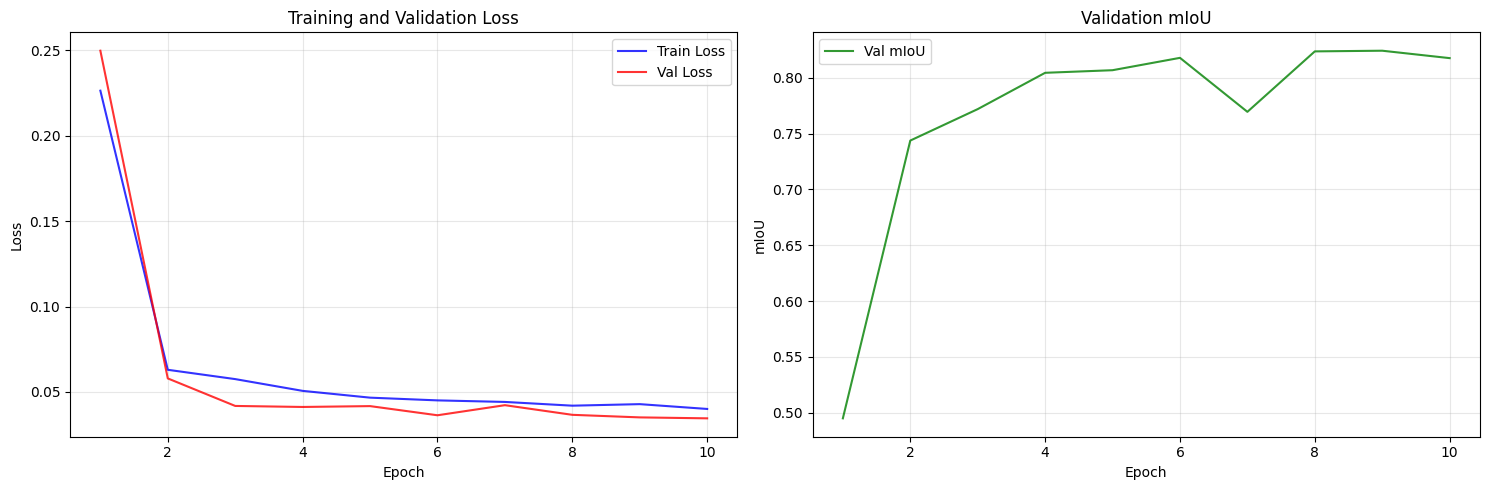

--------------------------------------------------------------------------------


Epoch 011/200 | Train: 0.0415 | Val: 0.0334 | mIoU: 0.820 | LR: 0.000993
  Per-class IoU: ['0.99', '0.65']
--------------------------------------------------------------------------------


Epoch 012/200 | Train: 0.0427 | Val: 0.0389 | mIoU: 0.817 | LR: 0.000991
  Per-class IoU: ['0.99', '0.65']
--------------------------------------------------------------------------------


Epoch 013/200 | Train: 0.0397 | Val: 0.0329 | mIoU: 0.831 | LR: 0.000990
  Per-class IoU: ['0.99', '0.67']
  ✓ New best model saved! (mIoU=0.831)
--------------------------------------------------------------------------------


Epoch 014/200 | Train: 0.0413 | Val: 0.0332 | mIoU: 0.809 | LR: 0.000988
  Per-class IoU: ['0.99', '0.63']
--------------------------------------------------------------------------------


Epoch 015/200 | Train: 0.0385 | Val: 0.0338 | mIoU: 0.815 | LR: 0.000986
  Per-class IoU: ['0.99', '0.64']
--------------------------------------------------------------------------------


Epoch 016/200 | Train: 0.0363 | Val: 0.0313 | mIoU: 0.834 | LR: 0.000984
  Per-class IoU: ['0.99', '0.68']
  ✓ New best model saved! (mIoU=0.834)
--------------------------------------------------------------------------------


Epoch 017/200 | Train: 0.0373 | Val: 0.0314 | mIoU: 0.837 | LR: 0.000982
  Per-class IoU: ['0.99', '0.69']
  ✓ New best model saved! (mIoU=0.837)
--------------------------------------------------------------------------------


Epoch 018/200 | Train: 0.0375 | Val: 0.0316 | mIoU: 0.832 | LR: 0.000980
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 019/200 | Train: 0.0358 | Val: 0.0301 | mIoU: 0.838 | LR: 0.000978
  Per-class IoU: ['0.99', '0.69']
  ✓ New best model saved! (mIoU=0.838)
--------------------------------------------------------------------------------


Epoch 020/200 | Train: 0.0371 | Val: 0.0314 | mIoU: 0.836 | LR: 0.000976
  Per-class IoU: ['0.99', '0.68']


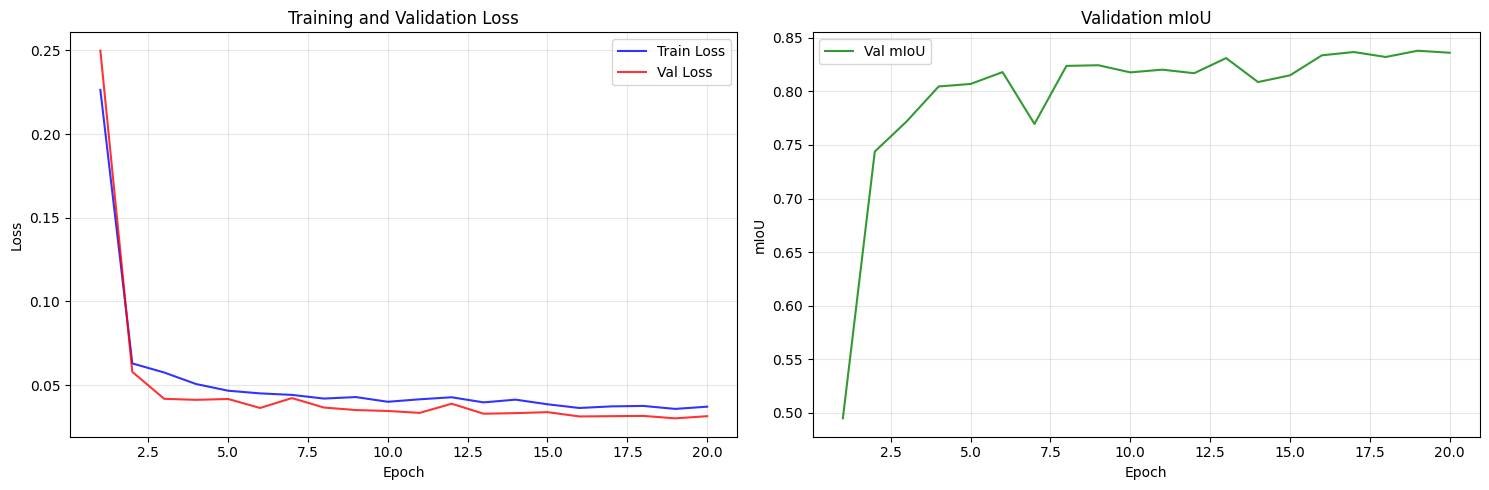

--------------------------------------------------------------------------------


Epoch 021/200 | Train: 0.0358 | Val: 0.0319 | mIoU: 0.816 | LR: 0.000973
  Per-class IoU: ['0.99', '0.64']
--------------------------------------------------------------------------------


Epoch 022/200 | Train: 0.0359 | Val: 0.0347 | mIoU: 0.795 | LR: 0.000970
  Per-class IoU: ['0.99', '0.60']
--------------------------------------------------------------------------------


Epoch 023/200 | Train: 0.0352 | Val: 0.0315 | mIoU: 0.836 | LR: 0.000968
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 024/200 | Train: 0.0347 | Val: 0.0304 | mIoU: 0.835 | LR: 0.000965
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 025/200 | Train: 0.0350 | Val: 0.0311 | mIoU: 0.832 | LR: 0.000962
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 026/200 | Train: 0.0340 | Val: 0.0318 | mIoU: 0.823 | LR: 0.000959
  Per-class IoU: ['0.99', '0.66']
--------------------------------------------------------------------------------


Epoch 027/200 | Train: 0.0334 | Val: 0.0316 | mIoU: 0.835 | LR: 0.000956
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 028/200 | Train: 0.0340 | Val: 0.0316 | mIoU: 0.828 | LR: 0.000952
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 029/200 | Train: 0.0338 | Val: 0.0312 | mIoU: 0.831 | LR: 0.000949
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 030/200 | Train: 0.0325 | Val: 0.0300 | mIoU: 0.837 | LR: 0.000946
  Per-class IoU: ['0.99', '0.69']


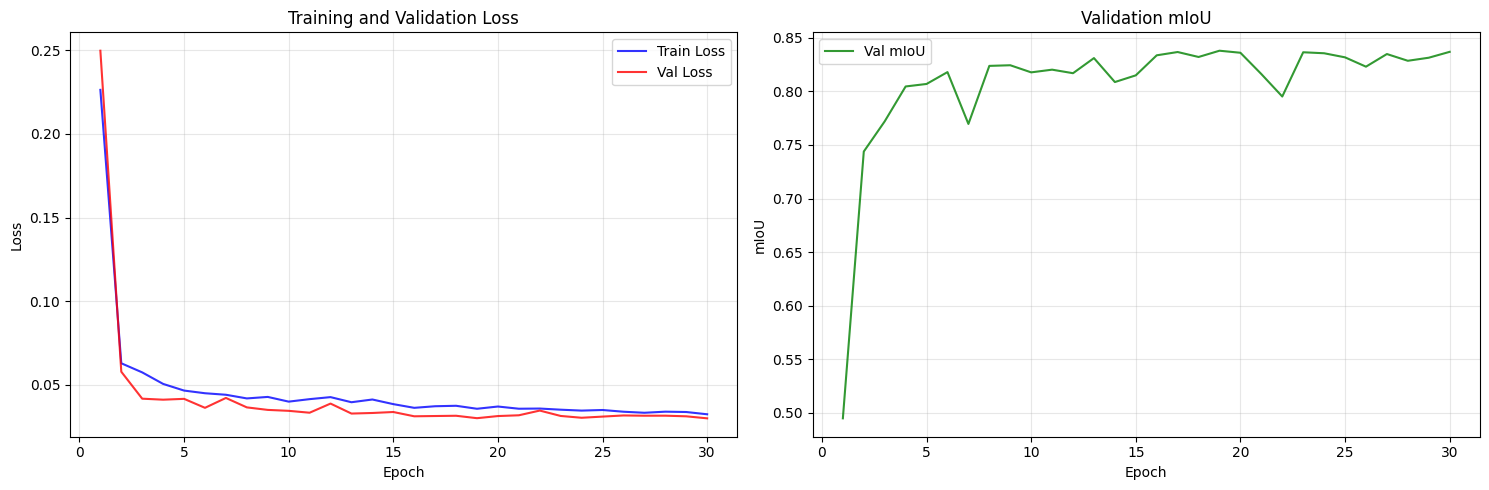

--------------------------------------------------------------------------------


Epoch 031/200 | Train: 0.0326 | Val: 0.0304 | mIoU: 0.843 | LR: 0.000942
  Per-class IoU: ['0.99', '0.70']
  ✓ New best model saved! (mIoU=0.843)
--------------------------------------------------------------------------------


Epoch 032/200 | Train: 0.0326 | Val: 0.0330 | mIoU: 0.828 | LR: 0.000938
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 033/200 | Train: 0.0317 | Val: 0.0321 | mIoU: 0.830 | LR: 0.000934
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 034/200 | Train: 0.0330 | Val: 0.0296 | mIoU: 0.834 | LR: 0.000930
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 035/200 | Train: 0.0313 | Val: 0.0321 | mIoU: 0.821 | LR: 0.000926
  Per-class IoU: ['0.99', '0.65']
--------------------------------------------------------------------------------


Epoch 036/200 | Train: 0.0328 | Val: 0.0311 | mIoU: 0.845 | LR: 0.000922
  Per-class IoU: ['0.99', '0.70']
  ✓ New best model saved! (mIoU=0.845)
--------------------------------------------------------------------------------


Epoch 037/200 | Train: 0.0309 | Val: 0.0318 | mIoU: 0.828 | LR: 0.000918
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 038/200 | Train: 0.0325 | Val: 0.0321 | mIoU: 0.845 | LR: 0.000914
  Per-class IoU: ['0.99', '0.70']
  ✓ New best model saved! (mIoU=0.845)
--------------------------------------------------------------------------------


Epoch 039/200 | Train: 0.0312 | Val: 0.0292 | mIoU: 0.844 | LR: 0.000909
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 040/200 | Train: 0.0305 | Val: 0.0311 | mIoU: 0.844 | LR: 0.000905
  Per-class IoU: ['0.99', '0.70']


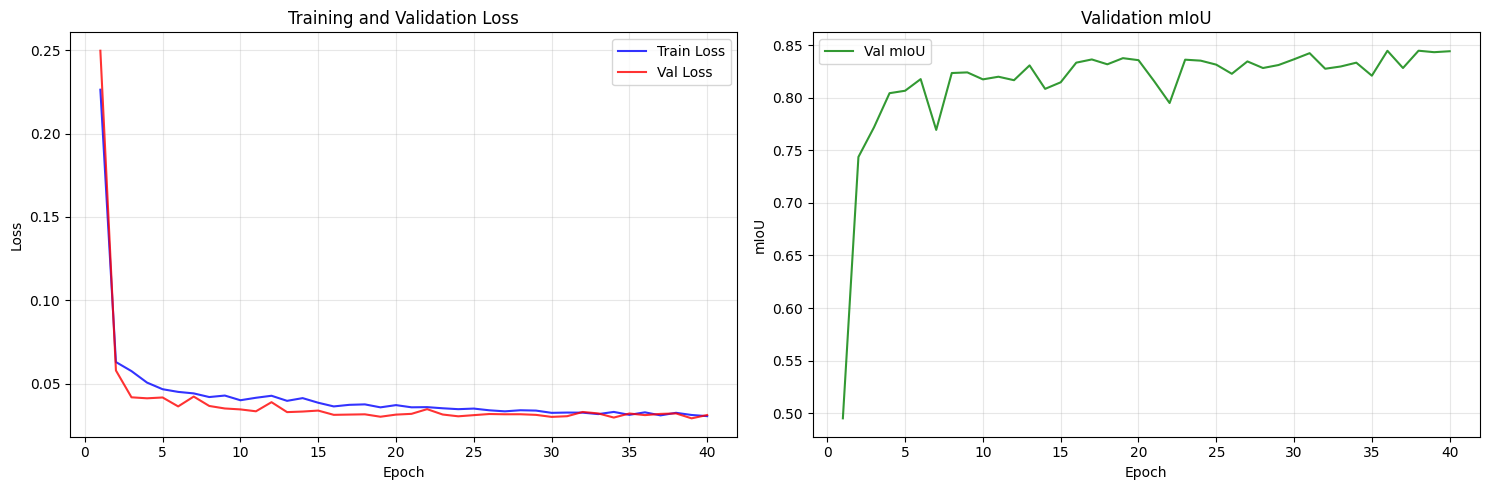

--------------------------------------------------------------------------------


Epoch 041/200 | Train: 0.0310 | Val: 0.0301 | mIoU: 0.836 | LR: 0.000900
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 042/200 | Train: 0.0336 | Val: 0.0350 | mIoU: 0.830 | LR: 0.000895
  Per-class IoU: ['0.99', '0.67']
--------------------------------------------------------------------------------


Epoch 043/200 | Train: 0.0322 | Val: 0.0316 | mIoU: 0.819 | LR: 0.000890
  Per-class IoU: ['0.99', '0.65']
--------------------------------------------------------------------------------


Epoch 044/200 | Train: 0.0301 | Val: 0.0292 | mIoU: 0.844 | LR: 0.000885
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 045/200 | Train: 0.0295 | Val: 0.0294 | mIoU: 0.847 | LR: 0.000880
  Per-class IoU: ['0.99', '0.71']
  ✓ New best model saved! (mIoU=0.847)
--------------------------------------------------------------------------------


Epoch 046/200 | Train: 0.0297 | Val: 0.0302 | mIoU: 0.838 | LR: 0.000875
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 047/200 | Train: 0.0301 | Val: 0.0293 | mIoU: 0.843 | LR: 0.000870
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 048/200 | Train: 0.0287 | Val: 0.0308 | mIoU: 0.844 | LR: 0.000864
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 049/200 | Train: 0.0283 | Val: 0.0294 | mIoU: 0.841 | LR: 0.000859
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 050/200 | Train: 0.0278 | Val: 0.0305 | mIoU: 0.831 | LR: 0.000854
  Per-class IoU: ['0.99', '0.67']


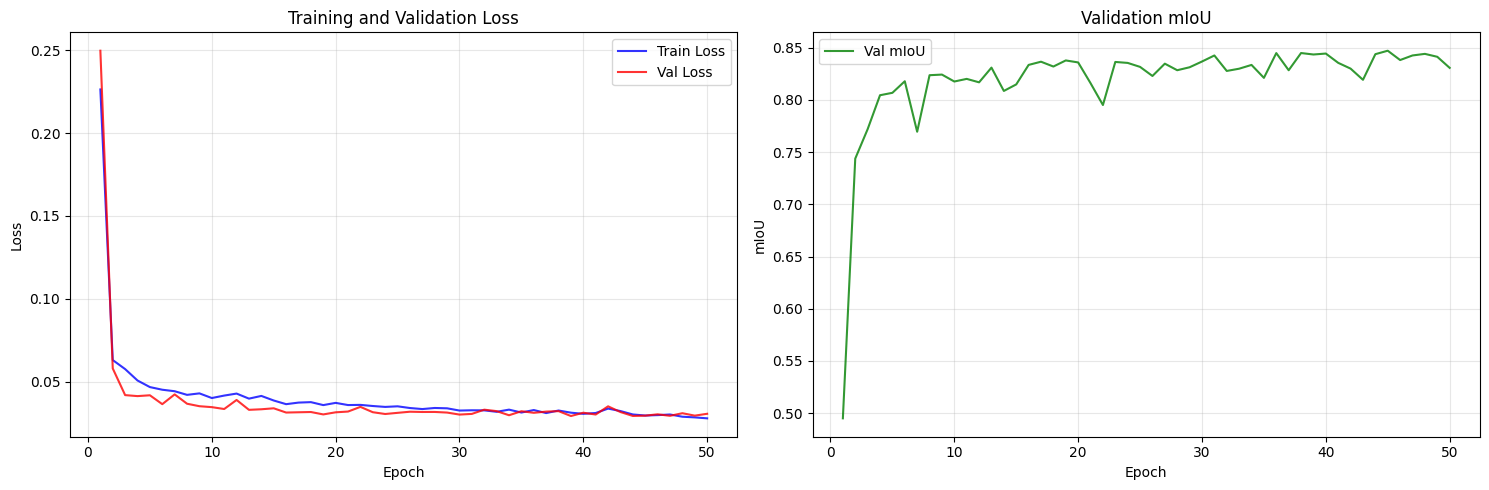

--------------------------------------------------------------------------------


Epoch 051/200 | Train: 0.0278 | Val: 0.0296 | mIoU: 0.837 | LR: 0.000848
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 052/200 | Train: 0.0275 | Val: 0.0306 | mIoU: 0.836 | LR: 0.000842
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 053/200 | Train: 0.0271 | Val: 0.0287 | mIoU: 0.844 | LR: 0.000837
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 054/200 | Train: 0.0273 | Val: 0.0306 | mIoU: 0.839 | LR: 0.000831
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 055/200 | Train: 0.0275 | Val: 0.0293 | mIoU: 0.842 | LR: 0.000825
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 056/200 | Train: 0.0273 | Val: 0.0295 | mIoU: 0.845 | LR: 0.000819
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 057/200 | Train: 0.0281 | Val: 0.0293 | mIoU: 0.837 | LR: 0.000813
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 058/200 | Train: 0.0283 | Val: 0.0320 | mIoU: 0.836 | LR: 0.000806
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 059/200 | Train: 0.0273 | Val: 0.0286 | mIoU: 0.848 | LR: 0.000800
  Per-class IoU: ['0.99', '0.71']
  ✓ New best model saved! (mIoU=0.848)
--------------------------------------------------------------------------------


Epoch 060/200 | Train: 0.0269 | Val: 0.0310 | mIoU: 0.845 | LR: 0.000794
  Per-class IoU: ['0.99', '0.70']


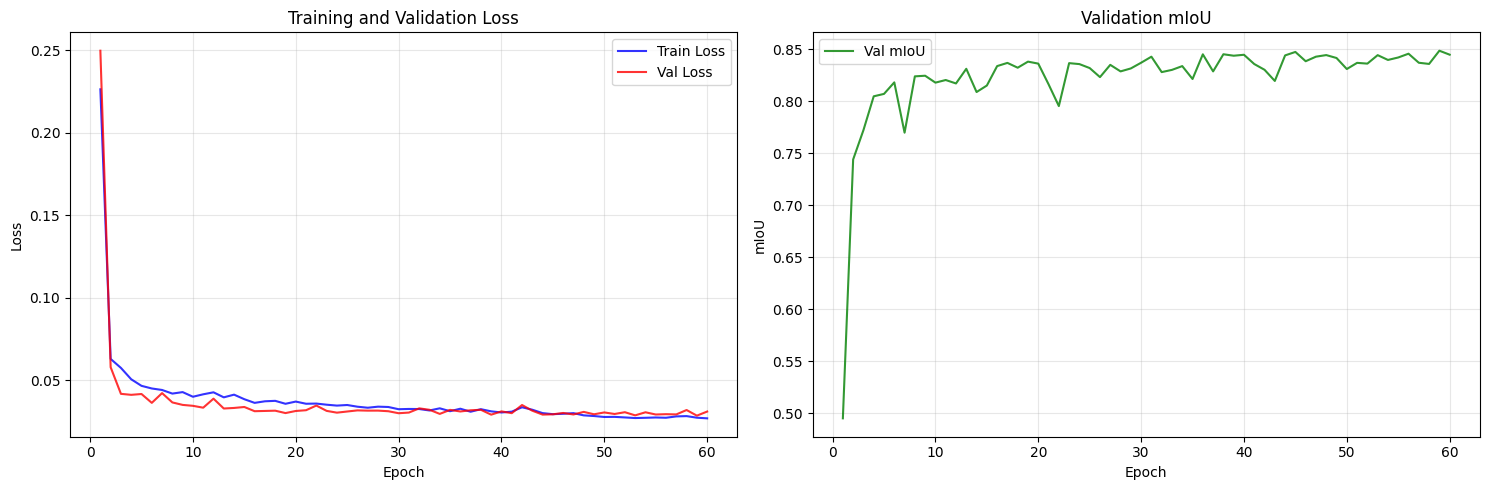

--------------------------------------------------------------------------------


Epoch 061/200 | Train: 0.0260 | Val: 0.0291 | mIoU: 0.846 | LR: 0.000788
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 062/200 | Train: 0.0266 | Val: 0.0286 | mIoU: 0.852 | LR: 0.000781
  Per-class IoU: ['0.99', '0.71']
  ✓ New best model saved! (mIoU=0.852)
--------------------------------------------------------------------------------


Epoch 063/200 | Train: 0.0256 | Val: 0.0290 | mIoU: 0.847 | LR: 0.000775
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 064/200 | Train: 0.0248 | Val: 0.0292 | mIoU: 0.845 | LR: 0.000768
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 065/200 | Train: 0.0250 | Val: 0.0299 | mIoU: 0.852 | LR: 0.000761
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 066/200 | Train: 0.0250 | Val: 0.0302 | mIoU: 0.843 | LR: 0.000755
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 067/200 | Train: 0.0245 | Val: 0.0311 | mIoU: 0.842 | LR: 0.000748
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 068/200 | Train: 0.0241 | Val: 0.0316 | mIoU: 0.836 | LR: 0.000741
  Per-class IoU: ['0.99', '0.68']
--------------------------------------------------------------------------------


Epoch 069/200 | Train: 0.0242 | Val: 0.0301 | mIoU: 0.843 | LR: 0.000734
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 070/200 | Train: 0.0242 | Val: 0.0304 | mIoU: 0.845 | LR: 0.000727
  Per-class IoU: ['0.99', '0.70']


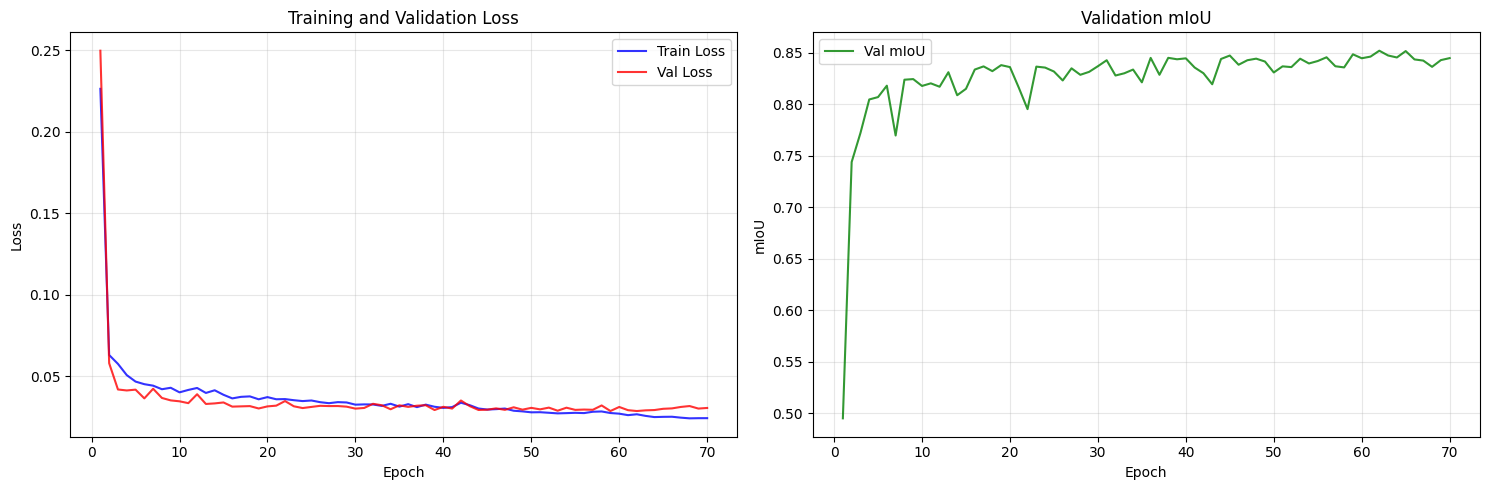

--------------------------------------------------------------------------------


Epoch 071/200 | Train: 0.0241 | Val: 0.0321 | mIoU: 0.845 | LR: 0.000720
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 072/200 | Train: 0.0240 | Val: 0.0318 | mIoU: 0.844 | LR: 0.000713
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 073/200 | Train: 0.0240 | Val: 0.0298 | mIoU: 0.853 | LR: 0.000706
  Per-class IoU: ['0.99', '0.72']
  ✓ New best model saved! (mIoU=0.853)
--------------------------------------------------------------------------------


Epoch 074/200 | Train: 0.0236 | Val: 0.0296 | mIoU: 0.844 | LR: 0.000699
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 075/200 | Train: 0.0247 | Val: 0.0300 | mIoU: 0.849 | LR: 0.000691
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 076/200 | Train: 0.0246 | Val: 0.0297 | mIoU: 0.854 | LR: 0.000684
  Per-class IoU: ['0.99', '0.72']
  ✓ New best model saved! (mIoU=0.854)
--------------------------------------------------------------------------------


Epoch 077/200 | Train: 0.0254 | Val: 0.0316 | mIoU: 0.842 | LR: 0.000677
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 078/200 | Train: 0.0247 | Val: 0.0338 | mIoU: 0.823 | LR: 0.000669
  Per-class IoU: ['0.99', '0.66']
--------------------------------------------------------------------------------


Epoch 079/200 | Train: 0.0237 | Val: 0.0317 | mIoU: 0.847 | LR: 0.000662
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 080/200 | Train: 0.0231 | Val: 0.0322 | mIoU: 0.843 | LR: 0.000655
  Per-class IoU: ['0.99', '0.70']


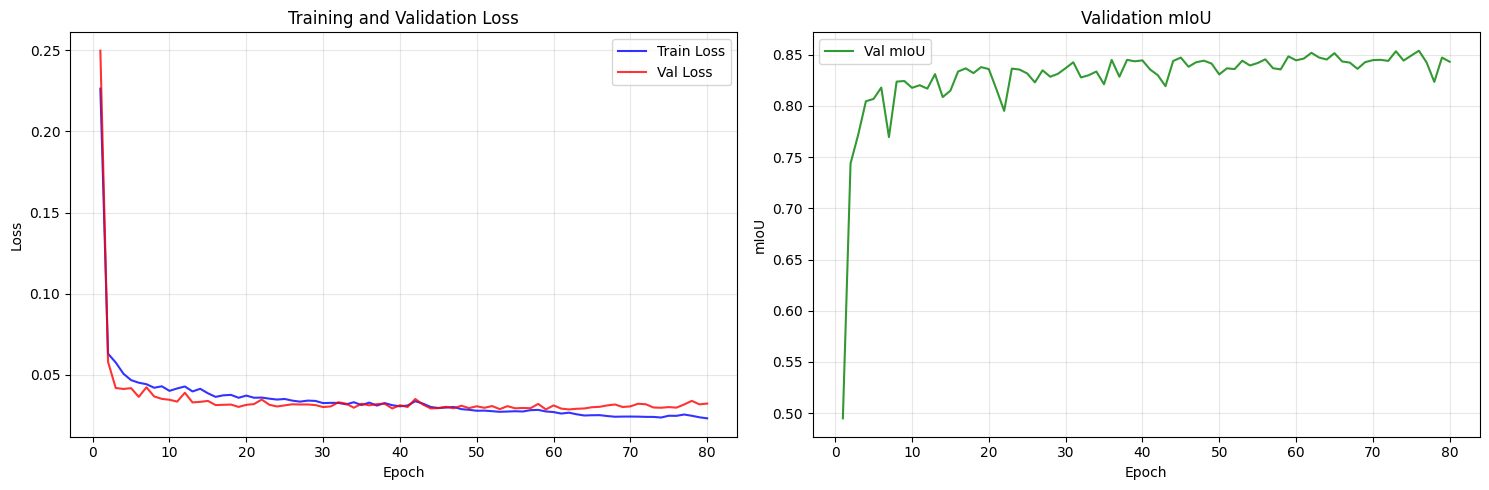

--------------------------------------------------------------------------------


Epoch 081/200 | Train: 0.0225 | Val: 0.0313 | mIoU: 0.850 | LR: 0.000647
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 082/200 | Train: 0.0225 | Val: 0.0312 | mIoU: 0.843 | LR: 0.000639
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 083/200 | Train: 0.0221 | Val: 0.0328 | mIoU: 0.837 | LR: 0.000632
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 084/200 | Train: 0.0222 | Val: 0.0350 | mIoU: 0.839 | LR: 0.000624
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 085/200 | Train: 0.0222 | Val: 0.0317 | mIoU: 0.845 | LR: 0.000617
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 086/200 | Train: 0.0222 | Val: 0.0331 | mIoU: 0.851 | LR: 0.000609
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 087/200 | Train: 0.0219 | Val: 0.0321 | mIoU: 0.844 | LR: 0.000601
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 088/200 | Train: 0.0221 | Val: 0.0316 | mIoU: 0.848 | LR: 0.000594
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 089/200 | Train: 0.0218 | Val: 0.0318 | mIoU: 0.843 | LR: 0.000586
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 090/200 | Train: 0.0212 | Val: 0.0339 | mIoU: 0.844 | LR: 0.000578
  Per-class IoU: ['0.99', '0.70']


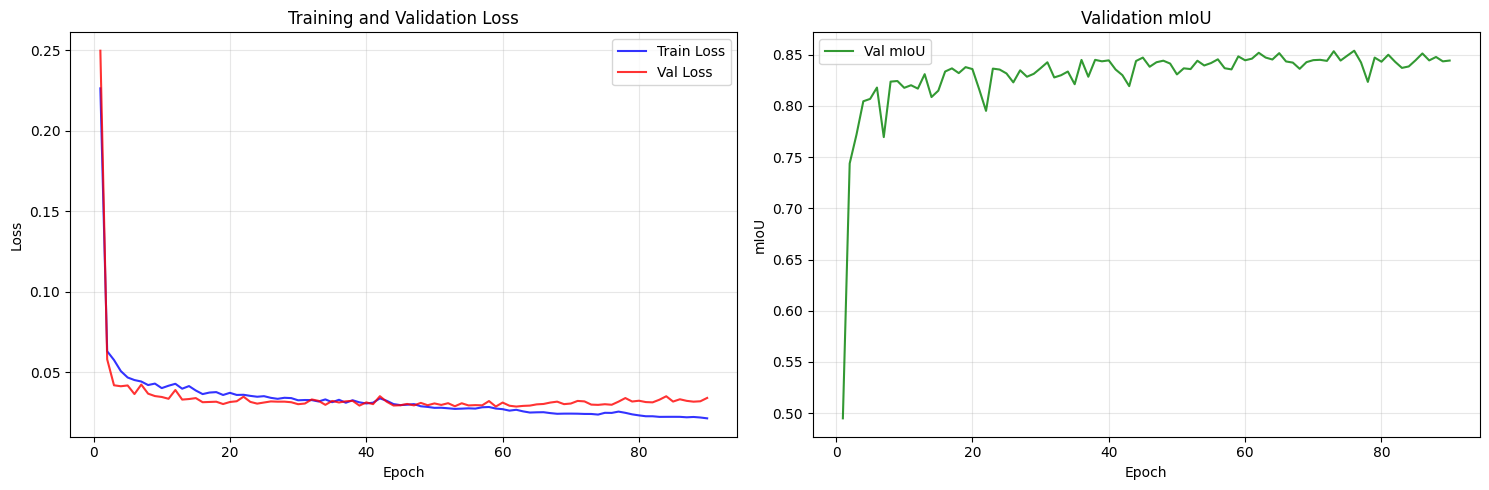

--------------------------------------------------------------------------------


Epoch 091/200 | Train: 0.0210 | Val: 0.0358 | mIoU: 0.843 | LR: 0.000570
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 092/200 | Train: 0.0210 | Val: 0.0353 | mIoU: 0.842 | LR: 0.000563
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 093/200 | Train: 0.0215 | Val: 0.0352 | mIoU: 0.848 | LR: 0.000555
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 094/200 | Train: 0.0211 | Val: 0.0333 | mIoU: 0.849 | LR: 0.000547
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 095/200 | Train: 0.0204 | Val: 0.0331 | mIoU: 0.853 | LR: 0.000539
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 096/200 | Train: 0.0203 | Val: 0.0338 | mIoU: 0.847 | LR: 0.000531
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 097/200 | Train: 0.0201 | Val: 0.0319 | mIoU: 0.850 | LR: 0.000524
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 098/200 | Train: 0.0206 | Val: 0.0321 | mIoU: 0.846 | LR: 0.000516
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 099/200 | Train: 0.0200 | Val: 0.0357 | mIoU: 0.847 | LR: 0.000508
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 100/200 | Train: 0.0199 | Val: 0.0344 | mIoU: 0.846 | LR: 0.000500
  Per-class IoU: ['0.99', '0.70']


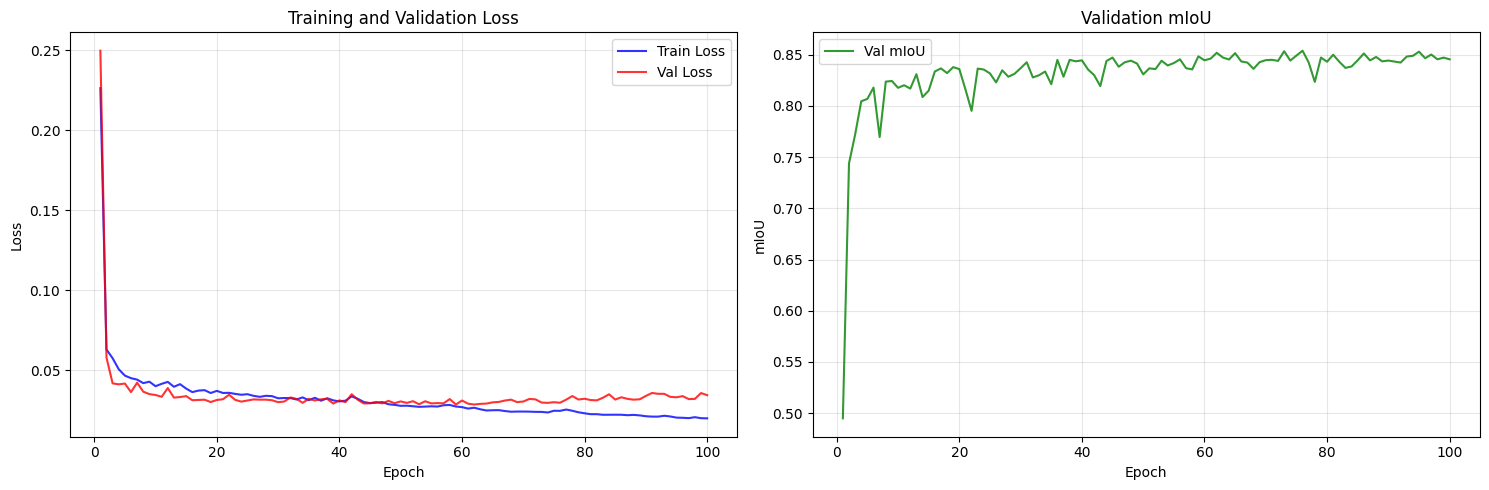

--------------------------------------------------------------------------------


Epoch 101/200 | Train: 0.0197 | Val: 0.0345 | mIoU: 0.847 | LR: 0.000492
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 102/200 | Train: 0.0197 | Val: 0.0332 | mIoU: 0.849 | LR: 0.000484
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 103/200 | Train: 0.0200 | Val: 0.0327 | mIoU: 0.852 | LR: 0.000476
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 104/200 | Train: 0.0195 | Val: 0.0341 | mIoU: 0.853 | LR: 0.000469
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 105/200 | Train: 0.0201 | Val: 0.0333 | mIoU: 0.848 | LR: 0.000461
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 106/200 | Train: 0.0198 | Val: 0.0345 | mIoU: 0.848 | LR: 0.000453
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 107/200 | Train: 0.0193 | Val: 0.0345 | mIoU: 0.848 | LR: 0.000445
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 108/200 | Train: 0.0198 | Val: 0.0334 | mIoU: 0.849 | LR: 0.000437
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 109/200 | Train: 0.0195 | Val: 0.0344 | mIoU: 0.847 | LR: 0.000430
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 110/200 | Train: 0.0194 | Val: 0.0345 | mIoU: 0.851 | LR: 0.000422
  Per-class IoU: ['0.99', '0.71']


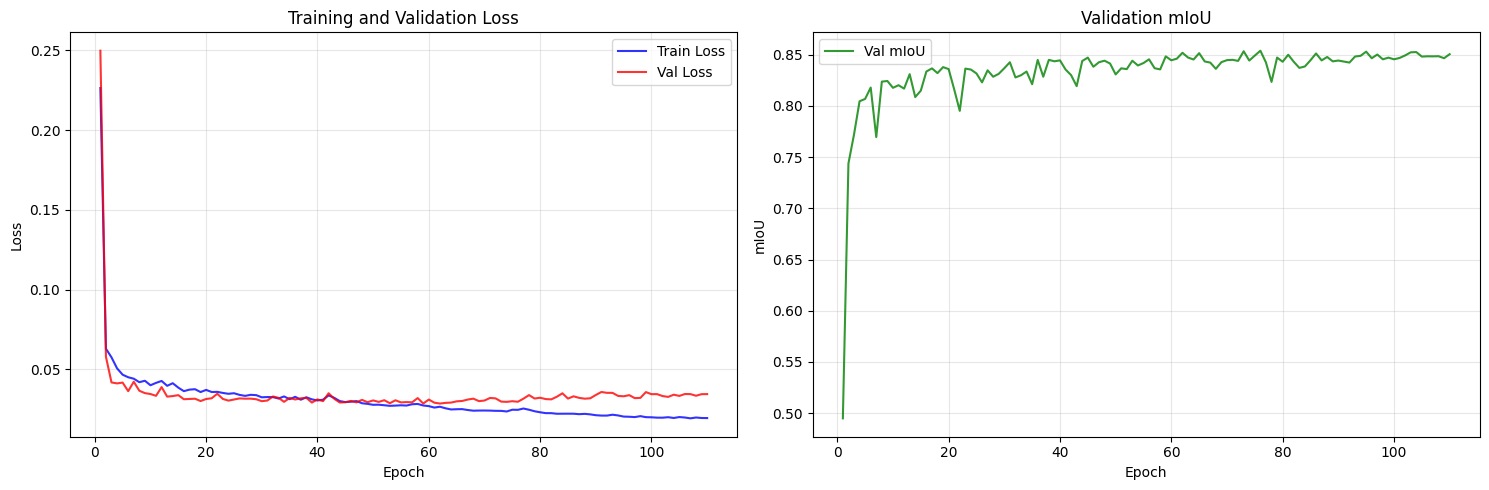

--------------------------------------------------------------------------------


Epoch 111/200 | Train: 0.0188 | Val: 0.0338 | mIoU: 0.852 | LR: 0.000414
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 112/200 | Train: 0.0190 | Val: 0.0344 | mIoU: 0.847 | LR: 0.000406
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 113/200 | Train: 0.0186 | Val: 0.0344 | mIoU: 0.851 | LR: 0.000399
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 114/200 | Train: 0.0184 | Val: 0.0361 | mIoU: 0.847 | LR: 0.000391
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 115/200 | Train: 0.0182 | Val: 0.0329 | mIoU: 0.852 | LR: 0.000383
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 116/200 | Train: 0.0179 | Val: 0.0348 | mIoU: 0.849 | LR: 0.000376
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 117/200 | Train: 0.0176 | Val: 0.0341 | mIoU: 0.851 | LR: 0.000368
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 118/200 | Train: 0.0177 | Val: 0.0366 | mIoU: 0.848 | LR: 0.000361
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 119/200 | Train: 0.0174 | Val: 0.0345 | mIoU: 0.852 | LR: 0.000353
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 120/200 | Train: 0.0176 | Val: 0.0352 | mIoU: 0.852 | LR: 0.000345
  Per-class IoU: ['0.99', '0.71']


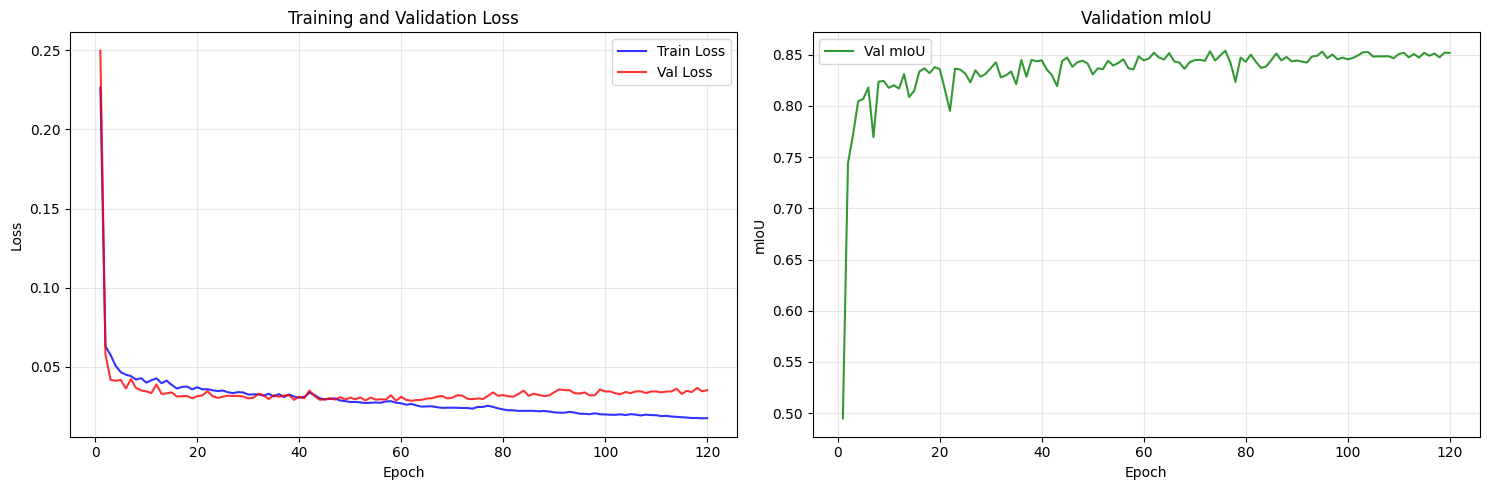

--------------------------------------------------------------------------------


Epoch 121/200 | Train: 0.0175 | Val: 0.0353 | mIoU: 0.854 | LR: 0.000338
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 122/200 | Train: 0.0175 | Val: 0.0369 | mIoU: 0.849 | LR: 0.000331
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 123/200 | Train: 0.0174 | Val: 0.0379 | mIoU: 0.845 | LR: 0.000323
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 124/200 | Train: 0.0174 | Val: 0.0357 | mIoU: 0.852 | LR: 0.000316
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 125/200 | Train: 0.0171 | Val: 0.0380 | mIoU: 0.845 | LR: 0.000309
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 126/200 | Train: 0.0171 | Val: 0.0354 | mIoU: 0.853 | LR: 0.000301
  Per-class IoU: ['0.99', '0.72']
--------------------------------------------------------------------------------


Epoch 127/200 | Train: 0.0170 | Val: 0.0388 | mIoU: 0.846 | LR: 0.000294
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 128/200 | Train: 0.0166 | Val: 0.0370 | mIoU: 0.848 | LR: 0.000287
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 129/200 | Train: 0.0166 | Val: 0.0367 | mIoU: 0.850 | LR: 0.000280
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 130/200 | Train: 0.0166 | Val: 0.0393 | mIoU: 0.848 | LR: 0.000273
  Per-class IoU: ['0.99', '0.71']


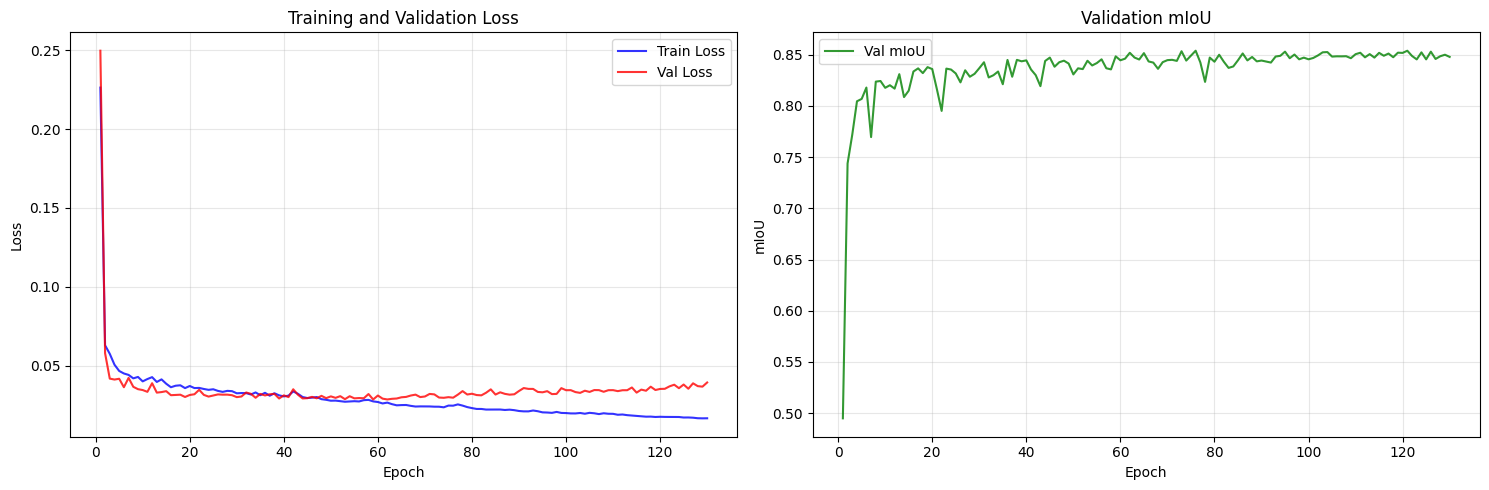

--------------------------------------------------------------------------------


Epoch 131/200 | Train: 0.0165 | Val: 0.0391 | mIoU: 0.848 | LR: 0.000266
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 132/200 | Train: 0.0163 | Val: 0.0371 | mIoU: 0.852 | LR: 0.000259
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 133/200 | Train: 0.0163 | Val: 0.0382 | mIoU: 0.851 | LR: 0.000252
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 134/200 | Train: 0.0158 | Val: 0.0399 | mIoU: 0.845 | LR: 0.000245
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 135/200 | Train: 0.0158 | Val: 0.0376 | mIoU: 0.848 | LR: 0.000239
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 136/200 | Train: 0.0157 | Val: 0.0391 | mIoU: 0.847 | LR: 0.000232
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 137/200 | Train: 0.0158 | Val: 0.0405 | mIoU: 0.845 | LR: 0.000225
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 138/200 | Train: 0.0156 | Val: 0.0394 | mIoU: 0.848 | LR: 0.000219
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 139/200 | Train: 0.0154 | Val: 0.0402 | mIoU: 0.847 | LR: 0.000212
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 140/200 | Train: 0.0153 | Val: 0.0419 | mIoU: 0.843 | LR: 0.000206
  Per-class IoU: ['0.99', '0.70']


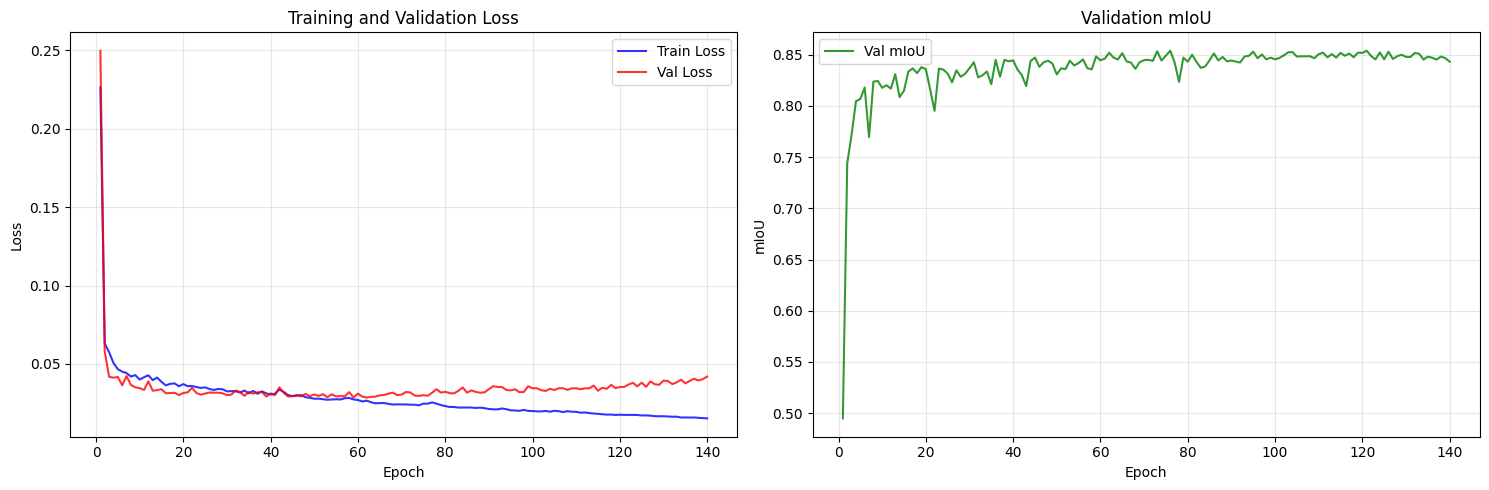

--------------------------------------------------------------------------------


Epoch 141/200 | Train: 0.0153 | Val: 0.0415 | mIoU: 0.849 | LR: 0.000200
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 142/200 | Train: 0.0151 | Val: 0.0398 | mIoU: 0.849 | LR: 0.000194
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 143/200 | Train: 0.0151 | Val: 0.0415 | mIoU: 0.845 | LR: 0.000187
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 144/200 | Train: 0.0150 | Val: 0.0417 | mIoU: 0.847 | LR: 0.000181
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 145/200 | Train: 0.0150 | Val: 0.0407 | mIoU: 0.849 | LR: 0.000175
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 146/200 | Train: 0.0147 | Val: 0.0420 | mIoU: 0.846 | LR: 0.000169
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 147/200 | Train: 0.0142 | Val: 0.0408 | mIoU: 0.846 | LR: 0.000163
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 148/200 | Train: 0.0143 | Val: 0.0414 | mIoU: 0.848 | LR: 0.000158
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 149/200 | Train: 0.0143 | Val: 0.0410 | mIoU: 0.846 | LR: 0.000152
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 150/200 | Train: 0.0144 | Val: 0.0414 | mIoU: 0.849 | LR: 0.000146
  Per-class IoU: ['0.99', '0.71']


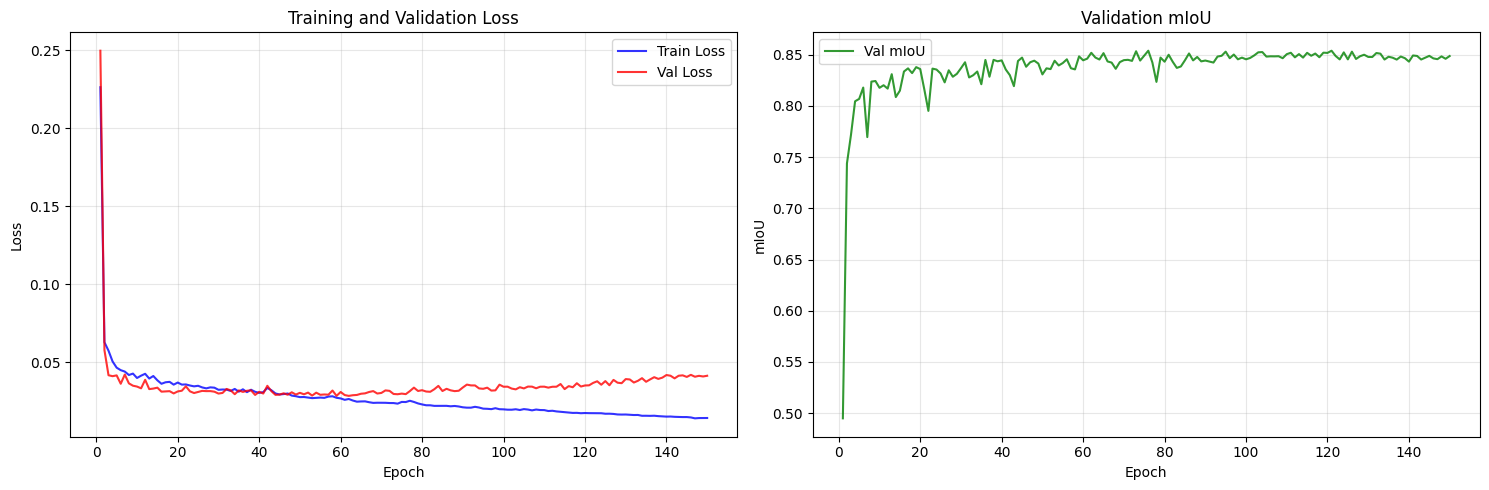

--------------------------------------------------------------------------------


Epoch 151/200 | Train: 0.0141 | Val: 0.0422 | mIoU: 0.846 | LR: 0.000141
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 152/200 | Train: 0.0140 | Val: 0.0417 | mIoU: 0.848 | LR: 0.000136
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 153/200 | Train: 0.0140 | Val: 0.0423 | mIoU: 0.846 | LR: 0.000130
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 154/200 | Train: 0.0139 | Val: 0.0429 | mIoU: 0.846 | LR: 0.000125
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 155/200 | Train: 0.0137 | Val: 0.0425 | mIoU: 0.846 | LR: 0.000120
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 156/200 | Train: 0.0133 | Val: 0.0448 | mIoU: 0.844 | LR: 0.000115
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 157/200 | Train: 0.0133 | Val: 0.0422 | mIoU: 0.847 | LR: 0.000110
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 158/200 | Train: 0.0131 | Val: 0.0431 | mIoU: 0.846 | LR: 0.000105
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 159/200 | Train: 0.0132 | Val: 0.0430 | mIoU: 0.847 | LR: 0.000100
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 160/200 | Train: 0.0133 | Val: 0.0425 | mIoU: 0.847 | LR: 0.000095
  Per-class IoU: ['0.99', '0.71']


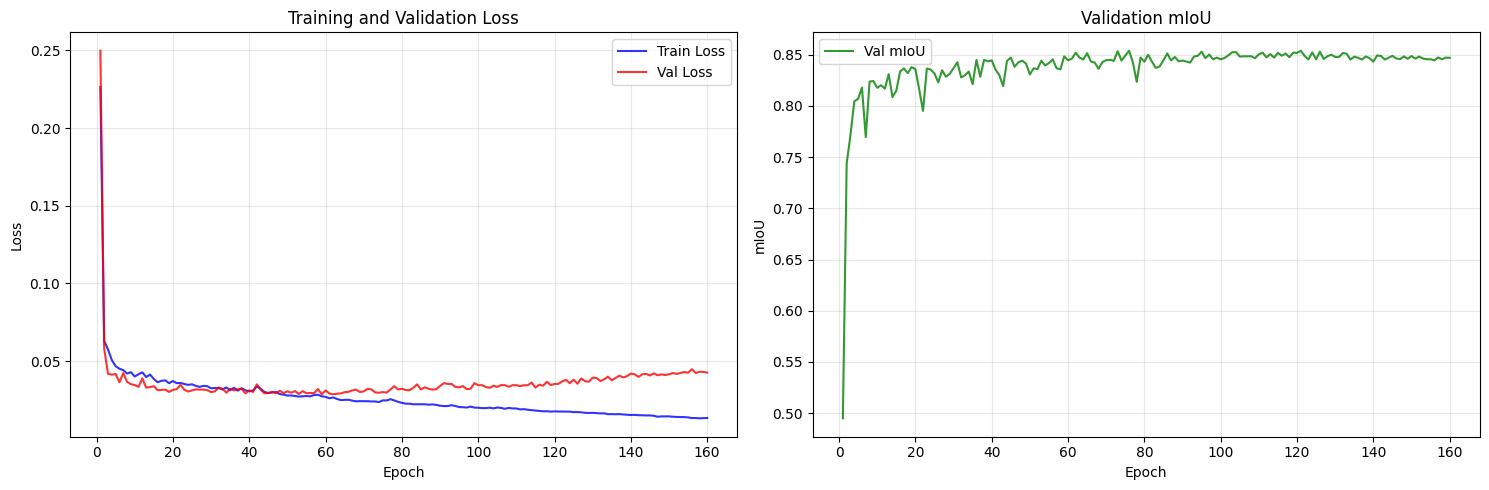

--------------------------------------------------------------------------------


Epoch 161/200 | Train: 0.0129 | Val: 0.0426 | mIoU: 0.849 | LR: 0.000091
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 162/200 | Train: 0.0128 | Val: 0.0452 | mIoU: 0.841 | LR: 0.000086
  Per-class IoU: ['0.99', '0.69']
--------------------------------------------------------------------------------


Epoch 163/200 | Train: 0.0127 | Val: 0.0439 | mIoU: 0.847 | LR: 0.000082
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 164/200 | Train: 0.0127 | Val: 0.0445 | mIoU: 0.844 | LR: 0.000078
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 165/200 | Train: 0.0128 | Val: 0.0432 | mIoU: 0.846 | LR: 0.000074
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 166/200 | Train: 0.0125 | Val: 0.0458 | mIoU: 0.845 | LR: 0.000070
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 167/200 | Train: 0.0123 | Val: 0.0435 | mIoU: 0.848 | LR: 0.000066
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 168/200 | Train: 0.0123 | Val: 0.0444 | mIoU: 0.845 | LR: 0.000062
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 169/200 | Train: 0.0120 | Val: 0.0455 | mIoU: 0.847 | LR: 0.000058
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 170/200 | Train: 0.0120 | Val: 0.0451 | mIoU: 0.846 | LR: 0.000054
  Per-class IoU: ['0.99', '0.70']


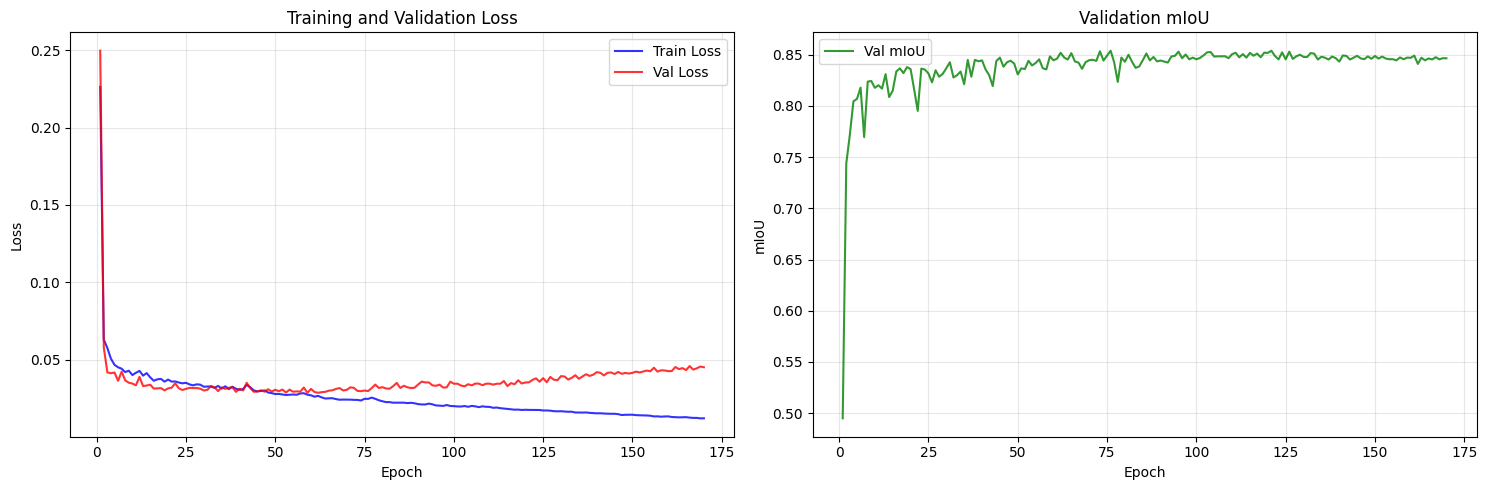

--------------------------------------------------------------------------------


Epoch 171/200 | Train: 0.0119 | Val: 0.0448 | mIoU: 0.847 | LR: 0.000051
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 172/200 | Train: 0.0118 | Val: 0.0449 | mIoU: 0.846 | LR: 0.000048
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 173/200 | Train: 0.0116 | Val: 0.0454 | mIoU: 0.848 | LR: 0.000044
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 174/200 | Train: 0.0117 | Val: 0.0448 | mIoU: 0.848 | LR: 0.000041
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 175/200 | Train: 0.0117 | Val: 0.0450 | mIoU: 0.846 | LR: 0.000038
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 176/200 | Train: 0.0116 | Val: 0.0442 | mIoU: 0.849 | LR: 0.000035
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 177/200 | Train: 0.0114 | Val: 0.0452 | mIoU: 0.846 | LR: 0.000032
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 178/200 | Train: 0.0115 | Val: 0.0463 | mIoU: 0.846 | LR: 0.000030
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 179/200 | Train: 0.0113 | Val: 0.0466 | mIoU: 0.846 | LR: 0.000027
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 180/200 | Train: 0.0114 | Val: 0.0464 | mIoU: 0.846 | LR: 0.000024
  Per-class IoU: ['0.99', '0.70']


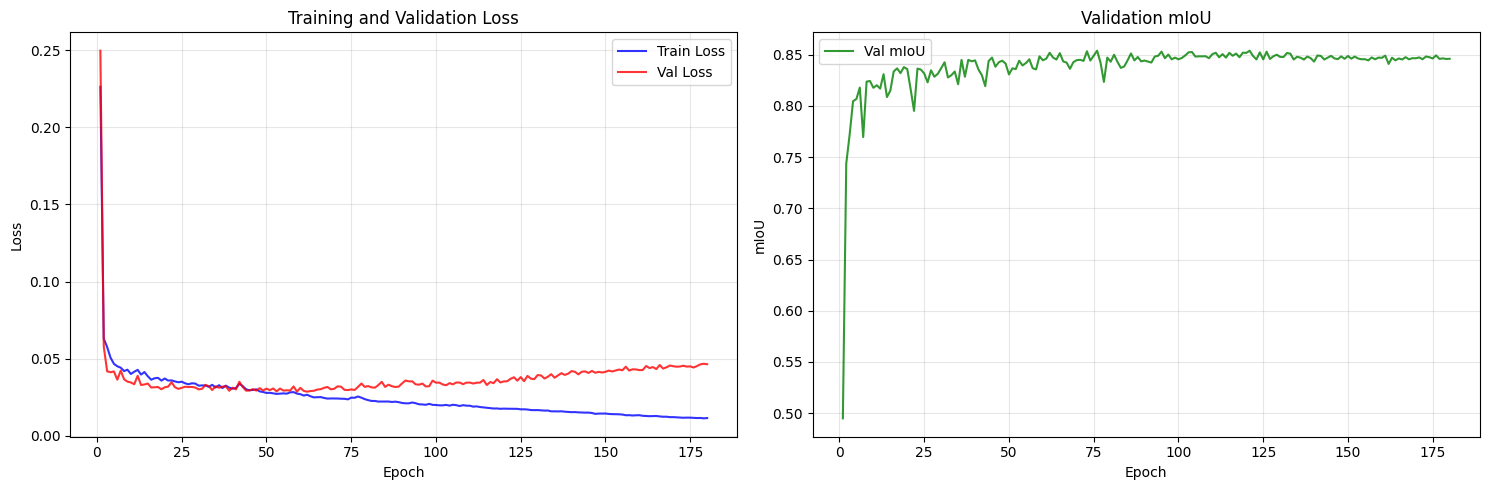

--------------------------------------------------------------------------------


Epoch 181/200 | Train: 0.0114 | Val: 0.0456 | mIoU: 0.847 | LR: 0.000022
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 182/200 | Train: 0.0113 | Val: 0.0459 | mIoU: 0.848 | LR: 0.000020
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 183/200 | Train: 0.0113 | Val: 0.0461 | mIoU: 0.848 | LR: 0.000018
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 184/200 | Train: 0.0113 | Val: 0.0457 | mIoU: 0.848 | LR: 0.000016
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 185/200 | Train: 0.0112 | Val: 0.0459 | mIoU: 0.848 | LR: 0.000014
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 186/200 | Train: 0.0113 | Val: 0.0459 | mIoU: 0.848 | LR: 0.000012
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 187/200 | Train: 0.0112 | Val: 0.0462 | mIoU: 0.848 | LR: 0.000010
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 188/200 | Train: 0.0111 | Val: 0.0464 | mIoU: 0.846 | LR: 0.000009
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 189/200 | Train: 0.0110 | Val: 0.0465 | mIoU: 0.845 | LR: 0.000007
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 190/200 | Train: 0.0111 | Val: 0.0466 | mIoU: 0.847 | LR: 0.000006
  Per-class IoU: ['0.99', '0.70']


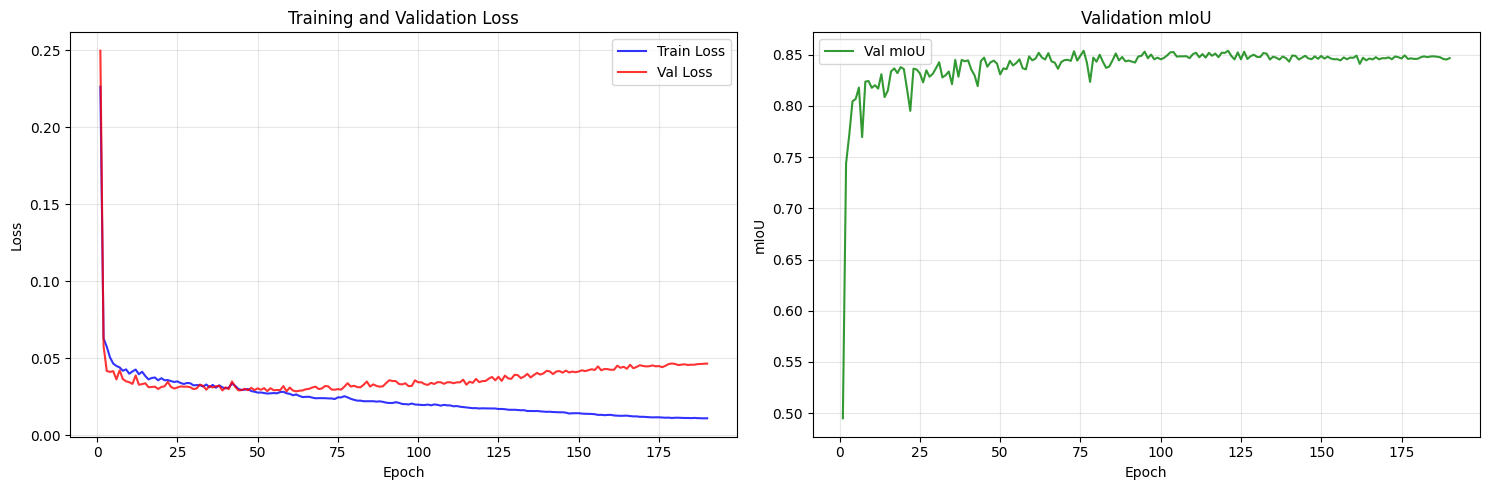

--------------------------------------------------------------------------------


Epoch 191/200 | Train: 0.0111 | Val: 0.0463 | mIoU: 0.847 | LR: 0.000005
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 192/200 | Train: 0.0110 | Val: 0.0462 | mIoU: 0.847 | LR: 0.000004
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 193/200 | Train: 0.0111 | Val: 0.0463 | mIoU: 0.847 | LR: 0.000003
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 194/200 | Train: 0.0111 | Val: 0.0462 | mIoU: 0.847 | LR: 0.000002
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 195/200 | Train: 0.0110 | Val: 0.0460 | mIoU: 0.848 | LR: 0.000002
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 196/200 | Train: 0.0110 | Val: 0.0460 | mIoU: 0.848 | LR: 0.000001
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 197/200 | Train: 0.0110 | Val: 0.0461 | mIoU: 0.847 | LR: 0.000001
  Per-class IoU: ['0.99', '0.70']
--------------------------------------------------------------------------------


Epoch 198/200 | Train: 0.0111 | Val: 0.0463 | mIoU: 0.847 | LR: 0.000000
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 199/200 | Train: 0.0111 | Val: 0.0460 | mIoU: 0.848 | LR: 0.000000
  Per-class IoU: ['0.99', '0.71']
--------------------------------------------------------------------------------


Epoch 200/200 | Train: 0.0112 | Val: 0.0462 | mIoU: 0.847 | LR: 0.000000
  Per-class IoU: ['0.99', '0.71']


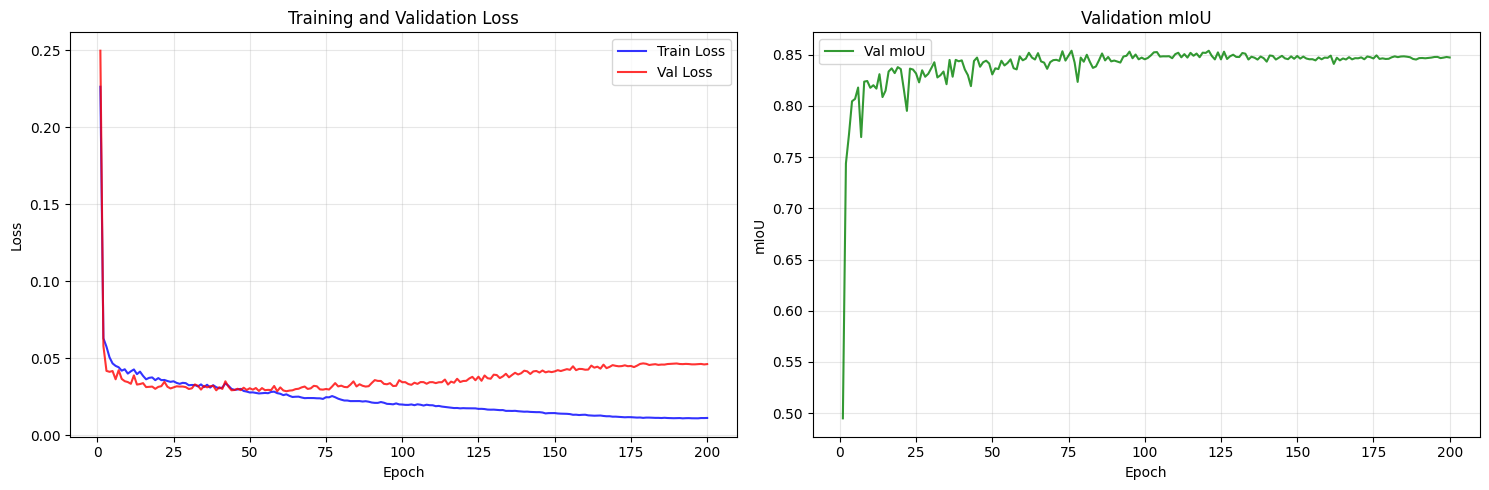

--------------------------------------------------------------------------------
Training completed! Best mIoU: 0.854


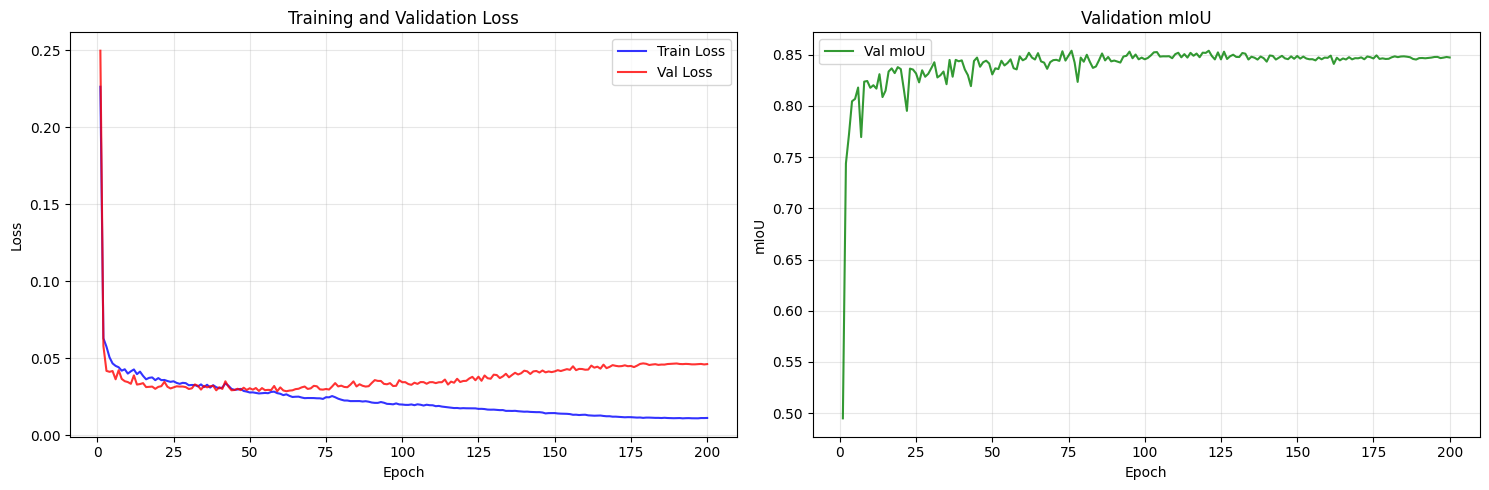

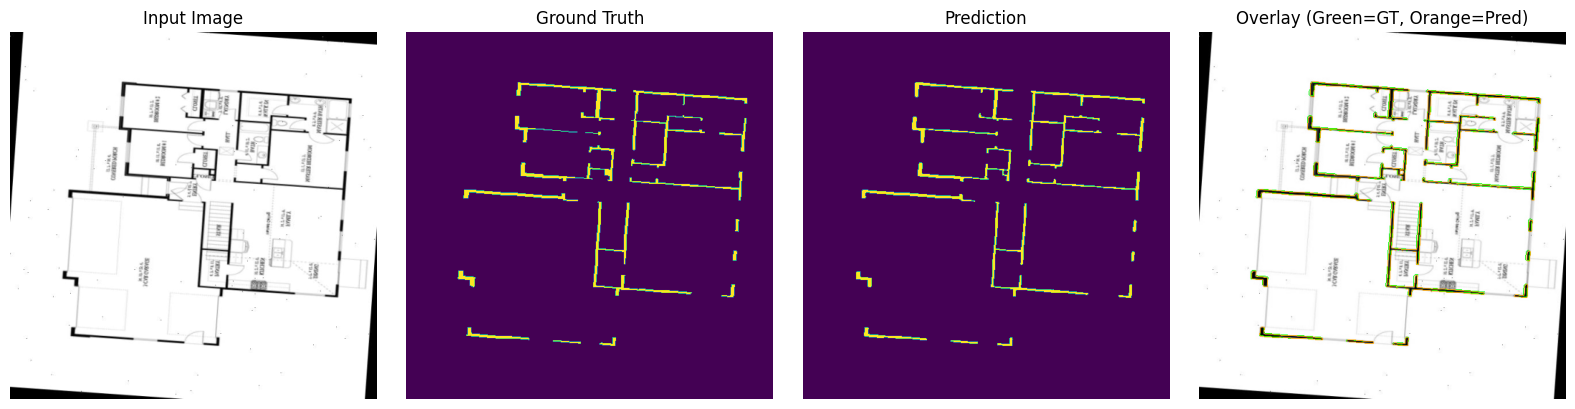

Results saved in: runs_unet_gray_resdrop_noalb
Files created:
  - unet_best.pth (best model, mIoU=0.854)
  - last.pth (latest model)
  - final_training_curves.png
  - sample_prediction.png


In [102]:
# train_unet_gray_resdrop_noalb.py
import os, random, cv2, numpy as np
from pathlib import Path
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ================== CONFIG ==================
DATA_ROOT   = r"C:\Users\win11\Desktop\Ebni\segmentation\datasetfinal"  # <-- EDIT
IMG_SIZE    = 512          # images/masks are 512x512; will enforce if different
ENFORCE_SIZE = True

IN_CHANNELS = 1            # grayscale
BASE_CH     = 64           # width multiplier
DROPOUT_P   = 0.20         # Dropout2d prob inside blocks
BOTTLENECK_DROPOUT_P = 0.30
RESIDUAL    = True         # residual adds in blocks

BATCH_SIZE  = 8
EPOCHS      = 200
LR          = 1e-3
WEIGHT_DECAY= 1e-4
AMP         = True
NUM_WORKERS = 0            # Windows/Notebook: start at 0; raise to 2 if stable
OUT_DIR     = "runs_unet_gray_resdrop_noalb"
SEED        = 42
# ============================================

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ---------------- Utils ----------------
def choose_val_name(root: Path) -> str:
    if (root/"val").exists():   return "val"
    if (root/"valid").exists(): return "valid"
    raise FileNotFoundError("Could not find 'val' or 'valid' split under DATA_ROOT.")

def to_index_mask(msk: np.ndarray) -> np.ndarray:
    """Single-channel integer mask from 1/3/4-channel input."""
    if msk.ndim == 2:  # H,W
        return msk.astype(np.int32)
    if msk.ndim == 3:
        C = msk.shape[2]
        if C == 1:    # H,W,1
            return msk[:, :, 0].astype(np.int32)
        rgb = msk[:, :, :3]  # drop alpha
        H, W, _ = rgb.shape
        flat = rgb.reshape(-1, 3)
        _, inv = np.unique(flat, axis=0, return_inverse=True)
        return inv.reshape(H, W).astype(np.int32)
    return np.squeeze(msk).astype(np.int32)

def discover_label_values(masks_dir: Path, max_files: int = 200) -> List[int]:
    vals = set()
    mask_files = list(masks_dir.glob("*.png"))
    print(f"Discovering labels from {len(mask_files)} mask files...")
    
    for i, p in enumerate(tqdm(mask_files[:max_files], desc="Scanning masks", 
                                  leave=False, position=0, ncols=100)):
        m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
        if m is None: continue
        idx = to_index_mask(m)
        vals.update(int(v) for v in np.unique(idx))
        if i+1 >= max_files: break
    return sorted(vals)

def build_label_mapping(vals: List[int]) -> Dict[int, int]:
    """Map observed mask values (e.g., [0,1] or [0,100,201]) to 0..K-1 (keep 0->0)."""
    if not vals: return {0: 0}
    remap, nxt = {}, 0
    if 0 in vals:
        remap[0] = 0
        nxt = 1
    for v in vals:
        if v == 0: continue
        remap[v] = nxt; nxt += 1
    return remap

def normalize_gray_01(x_hw: np.ndarray) -> np.ndarray:
    """uint8 HxW -> float32 HxW in [-1, 1] (mean=0.5, std=0.5)."""
    x = x_hw.astype(np.float32) / 255.0
    x = (x - 0.5) / 0.5
    return x

# ---------------- Dataset (NO AUGMENTATION) ----------------
class SegFolderDataset(Dataset):
    def __init__(self, split_dir: Path, label_map: Optional[Dict[int,int]] = None):
        self.img_dir = split_dir / "images"
        self.msk_dir = split_dir / "masks"
        self.paths = sorted([p for p in self.img_dir.glob("*.png") if (self.msk_dir/p.name).exists()])
        if not self.paths:
            raise FileNotFoundError(f"No pairs in {split_dir}. Expect images/ & masks/ with same .png names.")
        self.label_map = label_map or {}
        print(f"Found {len(self.paths)} image-mask pairs in {split_dir}")

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        ip = self.paths[i]; mp = self.msk_dir / ip.name

        try:
            # read grayscale as HxW (2D), then enforce size BEFORE adding channel
            img_hw = cv2.imread(str(ip), cv2.IMREAD_GRAYSCALE)
            if img_hw is None: 
                raise FileNotFoundError(f"Could not read image: {ip}")
            
            # Ensure image is 2D
            if img_hw.ndim != 2:
                # Only show warning for unexpected cases (not the common single-channel case)
                if not (img_hw.ndim == 3 and img_hw.shape[2] == 1):
                    print(f"Warning: Image {ip} has unexpected dimensions {img_hw.shape}, converting to 2D")
                if img_hw.ndim == 3:
                    if img_hw.shape[2] == 1:
                        # Single channel image with shape (H,W,1) - just squeeze it
                        img_hw = np.squeeze(img_hw, axis=2)
                    elif img_hw.shape[2] == 3:
                        # RGB/BGR image - convert to grayscale
                        img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2GRAY)
                    elif img_hw.shape[2] == 4:
                        # RGBA/BGRA image - convert to grayscale
                        img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGRA2GRAY)
                    else:
                        raise ValueError(f"Unsupported number of channels: {img_hw.shape[2]} in image {ip}")
                else:
                    img_hw = np.squeeze(img_hw)
                    if img_hw.ndim != 2:
                        raise ValueError(f"Cannot convert image {ip} to 2D, shape: {img_hw.shape}")
            
            if ENFORCE_SIZE and (img_hw.shape[0] != IMG_SIZE or img_hw.shape[1] != IMG_SIZE):
                img_hw = cv2.resize(img_hw, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

            # read mask, convert to index, enforce size
            mask_raw = cv2.imread(str(mp), cv2.IMREAD_UNCHANGED)
            if mask_raw is None: 
                raise FileNotFoundError(f"Could not read mask: {mp}")
            
            mask_hw = to_index_mask(mask_raw)
            if ENFORCE_SIZE and (mask_hw.shape[0] != IMG_SIZE or mask_hw.shape[1] != IMG_SIZE):
                mask_hw = cv2.resize(mask_hw, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            # normalize image, add channel, to tensor
            img_f = normalize_gray_01(img_hw)  # H,W in [-1,1]
            
            # Ensure we have the right shape before adding channel dimension
            if img_f.ndim != 2:
                raise ValueError(f"Normalized image has wrong dimensions: {img_f.shape}")
            
            # Add channel dimension: H,W -> H,W,1
            img_f = img_f[..., np.newaxis]  # H,W,1
            
            # Convert to tensor: H,W,1 -> 1,H,W
            x = torch.from_numpy(img_f.transpose(2, 0, 1)).float()

            # remap labels if needed
            if self.label_map:
                remapped = np.zeros_like(mask_hw, dtype=np.int32)
                for old, new in self.label_map.items():
                    remapped[mask_hw == old] = new
                mask_hw = remapped
            
            y = torch.from_numpy(mask_hw.astype(np.int64))  # [H,W] long
            return x, y
            
        except Exception as e:
            print(f"Error processing image {ip}: {e}")
            print(f"Image shape after loading: {img_hw.shape if 'img_hw' in locals() else 'Failed to load'}")
            raise

# --------------- U-Net (Residual + Dropout) ---------------
class ResDoubleConv(nn.Module):
    """Two 3x3 convs (BN+ReLU+Dropout) with residual add (1x1 skip if channels differ)."""
    def __init__(self, in_ch, out_ch, p_drop=DROPOUT_P, residual=RESIDUAL):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.act   = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout2d(p_drop) if p_drop and p_drop > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.skip  = nn.Conv2d(in_ch, out_ch, 1, bias=False) if in_ch != out_ch else nn.Identity()
        self.residual = residual

    def forward(self, x):
        identity = x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.drop(out)
        out = self.bn2(self.conv2(out))
        if self.residual:
            identity = self.skip(identity)
            out = out + identity
        out = self.act(out)
        return out

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=DROPOUT_P):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ResDoubleConv(in_ch, out_ch, p_drop=p_drop)
    def forward(self, x): return self.block(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=DROPOUT_P, bilinear=True):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False) if bilinear \
                  else nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.block = ResDoubleConv(in_ch, out_ch, p_drop=p_drop)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad if needed
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(x1, [diffX//2, diffX - diffX//2,
                                    diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)

class UNetResDrop(nn.Module):
    def __init__(self, in_channels=1, num_classes=1, base_ch=64,
                 p_drop=DROPOUT_P, p_drop_bottleneck=BOTTLENECK_DROPOUT_P):
        super().__init__()
        self.inc   = ResDoubleConv(in_channels, base_ch, p_drop=p_drop)
        self.down1 = Down(base_ch,   base_ch*2, p_drop=p_drop)
        self.down2 = Down(base_ch*2, base_ch*4, p_drop=p_drop)
        self.down3 = Down(base_ch*4, base_ch*8, p_drop=p_drop)
        self.down4 = Down(base_ch*8, base_ch*16, p_drop=p_drop_bottleneck)
        self.up1   = Up(base_ch*16 + base_ch*8, base_ch*8,  p_drop=p_drop)
        self.up2   = Up(base_ch*8  + base_ch*4, base_ch*4,  p_drop=p_drop)
        self.up3   = Up(base_ch*4  + base_ch*2, base_ch*2,  p_drop=p_drop)
        self.up4   = Up(base_ch*2  + base_ch,   base_ch,    p_drop=p_drop)
        self.outc  = nn.Conv2d(base_ch, num_classes, kernel_size=1)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x  = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1)
        return self.outc(x)

# --------------- Metrics ---------------
def iou_per_class(logits: torch.Tensor, target: torch.Tensor, num_classes: int) -> List[float]:
    with torch.no_grad():
        if logits.shape[1] == 1:
            pred = (logits.sigmoid() > 0.5).long().squeeze(1)  # [B,H,W]
        else:
            pred = logits.argmax(1)                             # [B,H,W]
        ious = []
        for c in range(num_classes):
            p = (pred == c); t = (target == c)
            inter = (p & t).sum().item()
            union = (p | t).sum().item()
            ious.append(inter / (union + 1e-6) if union > 0 else float("nan"))
        return ious

# --------------- Visualization ---------------
def plot_training_curves(train_losses, val_losses, val_mious, save_path):
    """Plot training curves and save them."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # mIoU plot
    ax2.plot(epochs, val_mious, 'g-', label='Val mIoU', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('mIoU')
    ax2.set_title('Validation mIoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_sample_prediction_visualization(model, val_ds, device, binary, save_path):
    """Create a visualization of model predictions on a sample."""
    try:
        model.eval()
        samp = random.randrange(len(val_ds))
        xb, yb = val_ds[samp]
        
        with torch.no_grad():
            pred = model(xb.unsqueeze(0).to(device))
            if binary:
                pm = (pred.sigmoid() > 0.5).long().squeeze().cpu().numpy()
            else:
                pm = pred.argmax(1).squeeze().cpu().numpy()
        
        # denorm grayscale: x in [-1,1] -> [0,1]
        xg = xb.squeeze().numpy()
        xg = np.clip((xg * 0.5 + 0.5), 0, 1)
        
        # Create visualization
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Original image
        axes[0].imshow(xg, cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')
        
        # Ground truth
        axes[1].imshow(yb.numpy(), cmap='viridis')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        
        # Prediction
        axes[2].imshow(pm, cmap='viridis')
        axes[2].set_title('Prediction')
        axes[2].axis('off')
        
        # Overlay
        rgb = np.stack([xg, xg, xg], axis=-1)
        edge_pred = cv2.Canny((pm > 0).astype(np.uint8) * 255, 50, 150) > 0
        edge_gt = cv2.Canny((yb.numpy() > 0).astype(np.uint8) * 255, 50, 150) > 0
        vis = rgb.copy()
        vis[edge_gt] = [0, 1, 0]      # Green for GT
        vis[edge_pred] = [1, 0.65, 0] # Orange for prediction
        
        axes[3].imshow(vis)
        axes[3].set_title('Overlay (Green=GT, Orange=Pred)')
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Visualization error: {e}")

# --------------- Train ---------------
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    root = Path(DATA_ROOT)
    if not root.exists():
        raise FileNotFoundError(f"Data root not found: {DATA_ROOT}")
    
    train_dir = root/"train"
    val_dir   = root/choose_val_name(root)
    
    print(f"Train dir: {train_dir}")
    print(f"Val dir: {val_dir}")

    # discover classes, build mapping
    label_vals = discover_label_values(train_dir/"masks", max_files=5000)
    label_map  = build_label_mapping(label_vals)
    num_classes = max(label_map.values()) + 1
    binary      = (num_classes == 2 and 0 in label_map.values())
    print(f"Label values: {label_vals}")
    print(f"Label map: {label_map} | num_classes={num_classes} | binary={binary}")

    # datasets/dataloaders (NO augmentation)
    train_ds = SegFolderDataset(train_dir, label_map=label_map)
    val_ds   = SegFolderDataset(val_dir,   label_map=label_map)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

    # model/opt/loss
    model = UNetResDrop(in_channels=IN_CHANNELS,
                        num_classes=(1 if binary else num_classes),
                        base_ch=BASE_CH).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    criterion = nn.BCEWithLogitsLoss() if binary else nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    out_dir = Path(OUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)
    best_miou = -1.0
    
    # Training history for plotting
    train_losses, val_losses, val_mious = [], [], []

    print(f"\nStarting training for {EPOCHS} epochs...")
    print("="*80)
    
    for epoch in range(1, EPOCHS+1):
        # ---- train ----
        model.train()
        tr_loss = 0.0
        
        train_pbar = tqdm(train_dl, desc=f"Epoch {epoch:03d}/{EPOCHS} [Train]", 
                         leave=False, dynamic_ncols=True, position=0, ncols=100)
        
        for xb, yb in train_pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast(enabled=AMP):
                logits = model(xb)
                loss = criterion(logits.squeeze(1) if binary else logits,
                                 (yb>0).float() if binary else yb)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            tr_loss += loss.item() * xb.size(0)
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        tr_loss /= len(train_ds)

        # ---- val ----
        model.eval()
        va_loss = 0.0
        iou_sum = np.zeros(num_classes, dtype=np.float64)
        iou_cnt = np.zeros(num_classes, dtype=np.int64)
        
        val_pbar = tqdm(val_dl, desc=f"Epoch {epoch:03d}/{EPOCHS} [Val]", 
                       leave=False, dynamic_ncols=True, position=0, ncols=100)
        
        with torch.no_grad():
            for xb, yb in val_pbar:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits.squeeze(1) if binary else logits,
                                 (yb>0).float() if binary else yb)
                va_loss += loss.item() * xb.size(0)
                
                ious = iou_per_class(logits, yb, num_classes)
                for c, v in enumerate(ious):
                    if v == v:  # not NaN
                        iou_sum[c] += v
                        iou_cnt[c] += 1
                
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        va_loss /= len(val_ds)
        per_cls = [(iou_sum[c]/max(1,iou_cnt[c])) if iou_cnt[c]>0 else float("nan")
                   for c in range(num_classes)]
        miou = float(np.nanmean(per_cls))
        
        scheduler.step()
        
        # Store metrics for plotting
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        val_mious.append(miou)

        print(f"Epoch {epoch:03d}/{EPOCHS} | Train: {tr_loss:.4f} | Val: {va_loss:.4f} | "
              f"mIoU: {miou:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"  Per-class IoU: {[f'{x:.2f}' if x==x else 'nan' for x in per_cls]}")

        # save latest model
        torch.save({
            "epoch": epoch, 
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "scaler": scaler.state_dict(),
            "label_map": label_map, 
            "in_channels": IN_CHANNELS,
            "num_classes": (1 if binary else num_classes),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_mious": val_mious
        }, out_dir/"last.pth")
        
        # save best model
        if miou > best_miou:
            best_miou = miou
            torch.save({
                "epoch": epoch, 
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "label_map": label_map, 
                "in_channels": IN_CHANNELS,
                "num_classes": (1 if binary else num_classes),
                "best_miou": best_miou
            }, out_dir/"unet_best.pth")
            print(f"  ✓ New best model saved! (mIoU={best_miou:.3f})")
        
        # Plot training curves every 10 epochs or at the end
        if epoch % 10 == 0 or epoch == EPOCHS:
            plot_training_curves(train_losses, val_losses, val_mious, 
                                out_dir/f"training_curves_epoch_{epoch:03d}.png")
        
        print("-" * 80)

    print("="*80)
    print(f"Training completed! Best mIoU: {best_miou:.3f}")
    
    # Final plots and visualization
    plot_training_curves(train_losses, val_losses, val_mious, 
                        out_dir/"final_training_curves.png")
    
    # Load best model for final visualization
    best_checkpoint = torch.load(out_dir/"unet_best.pth", map_location=device)
    model.load_state_dict(best_checkpoint["model"])
    
    create_sample_prediction_visualization(model, val_ds, device, binary, 
                                         out_dir/"sample_prediction.png")
    
    print(f"Results saved in: {out_dir}")
    print("Files created:")
    print(f"  - unet_best.pth (best model, mIoU={best_miou:.3f})")
    print(f"  - last.pth (latest model)")
    print(f"  - final_training_curves.png")
    print(f"  - sample_prediction.png")

if __name__ == "__main__":
    main()